In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr

from scipy.ndimage import gaussian_filter1d

import seaborn as sns

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #Define letter heights and colors
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    #Choose color
    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    #Draw letter onto axis
    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    
    return p

#Function to plot sequence logo
def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    
    #Loop over reference sequence letters
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    #Loop over reference sequence letters and draw
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    #Set axis limits
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


In [2]:
#Load gene dataframe and select tissue

tissue = 'brain_cortex'

top_n = 200

gene_df = pd.read_csv("/home/jlinder/seqnn/data/diff_expr/gtex_diff_expr_log2fc_5k.csv", sep='\t')
gene_df = gene_df.query("tissue == '" + str(tissue) + "'").copy().reset_index(drop=True)
gene_df = gene_df.drop(columns=['Unnamed: 0'])

#Select top N
gene_df = gene_df.iloc[:top_n].copy().reset_index(drop=True)

print("len(gene_df) = " + str(len(gene_df)))

#Get list of gene for tissue
tissue_genes = gene_df['gene_base'].values.tolist()

print("len(tissue_genes) = " + str(len(tissue_genes)))


len(gene_df) = 200
len(tissue_genes) = 200


In [3]:
#Load scores for the selected set of GTEx tissues (grad)

import gc

gtex_tissues = ['blood', 'liver', 'brain', 'muscle', 'esophagus']

seqs = None
strands = None
chrs = None
starts = None
ends = None
genes = None

all_scores_hyp = []
all_scores = []

#Loop over tissues
for gtex_tissue in gtex_tissues :
    
    print("tissue = '" + gtex_tissue + "'")

    score_file = h5py.File('scores_v2/gtex_' + gtex_tissue + '_log2fc_undo_clip_scores_mean.h5', 'r')

    #Get scores and onehots
    scores = score_file['grads'][()][..., 0]
    seqs = score_file['seqs'][()]

    #Get auxiliary information
    strands = score_file['strand'][()]
    strands = np.array([strands[j].decode() for j in range(strands.shape[0])])

    chrs = score_file['chr'][()]
    chrs = np.array([chrs[j].decode() for j in range(chrs.shape[0])])

    starts = np.array(score_file['start'][()])
    ends = np.array(score_file['end'][()])

    genes = score_file['gene'][()]
    genes = np.array([genes[j].decode().split(".")[0] for j in range(genes.shape[0])])
    
    gene_dict = {gene : gene_i for gene_i, gene in enumerate(genes.tolist())}

    #Get index of rows to keep
    keep_index = []
    for tissue_gene in tissue_genes :
        keep_index.append(gene_dict[tissue_gene])

    #Filter/sub-select data
    scores = scores[keep_index, ...]
    seqs = seqs[keep_index, ...]
    strands = strands[keep_index]
    chrs = chrs[keep_index]
    starts = starts[keep_index]
    ends = ends[keep_index]
    genes = genes[keep_index]

    #Append hypothetical scores
    all_scores_hyp.append(scores[None, ...])

    #Append input-gated scores
    all_scores.append((scores * seqs)[None, ...])

    #Collect garbage
    gc.collect()

#Collect final scores
scores_hyp = np.concatenate(all_scores_hyp, axis=0)
scores = np.concatenate(all_scores, axis=0)

print("scores_hyp.shape = " + str(scores_hyp.shape))
print("scores.shape = " + str(scores.shape))

score_file = None

#Collect garbage
gc.collect()


tissue = 'blood'
tissue = 'liver'
tissue = 'brain'
tissue = 'muscle'
tissue = 'esophagus'
scores_hyp.shape = (5, 200, 524288, 4)
scores.shape = (5, 200, 524288, 4)


0

-- Example = 0 --
 - ENSG00000006116(+)
 - chr16:24063923-24588211
 -- min_val = -0.2076
 -- max_val = 0.3132
 - (Gradient score profiles per tissue) - 


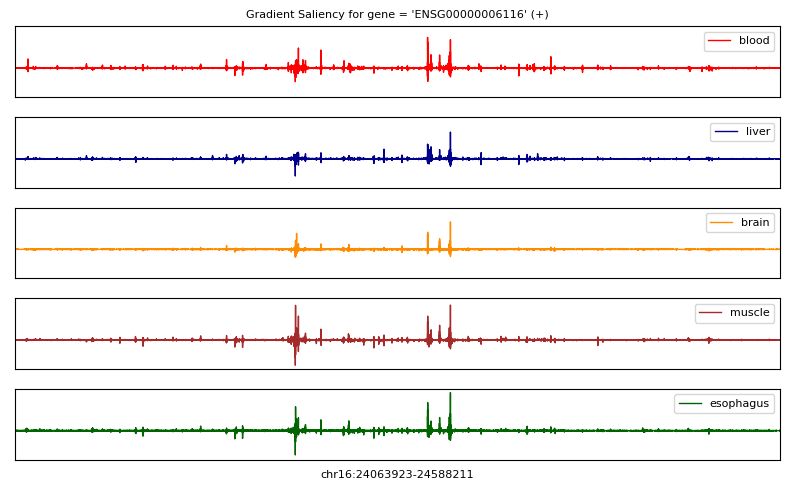

 - (Gradient score comparison against 'brain') - 
blood (r = 0.437)
liver (r = 0.429)
muscle (r = 0.465)
esophagus (r = 0.616)


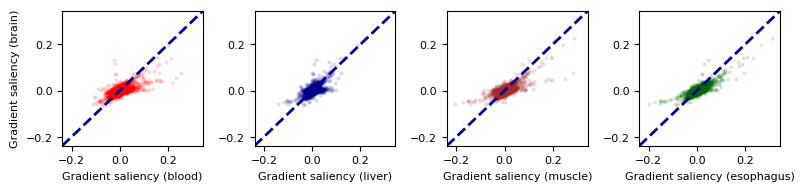

 - (Differential gradient score of brain against 'mean') -


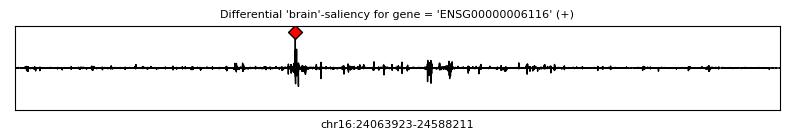

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 192169
 - max_pos (abs) = 24256092
 - chr16:24255996-24256188
blood


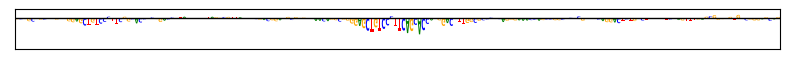

liver


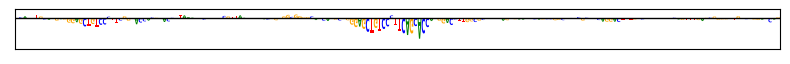

brain


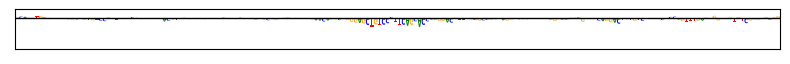

muscle


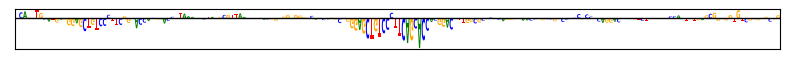

esophagus


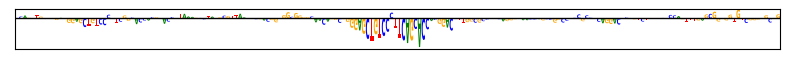

--------------------

-- Example = 1 --
 - ENSG00000165643(-)
 - chr9:135433922-135958210
 -- min_val = -0.627
 -- max_val = 1.037
 - (Gradient score profiles per tissue) - 


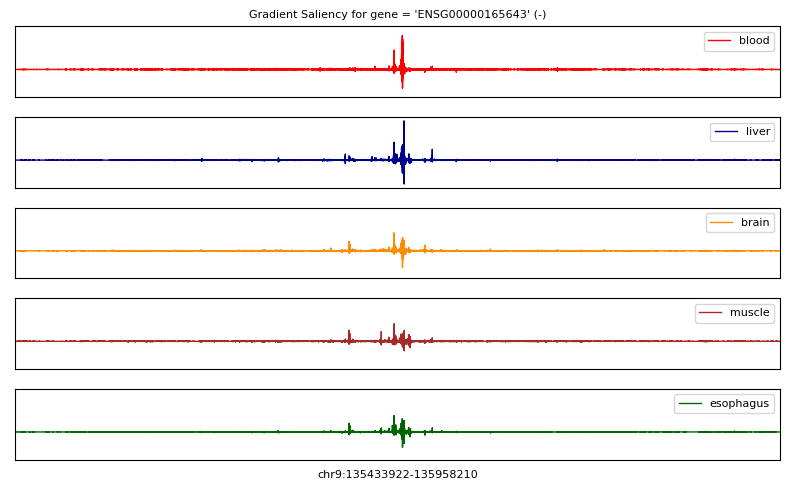

 - (Gradient score comparison against 'brain') - 
blood (r = 0.353)
liver (r = 0.399)
muscle (r = 0.534)
esophagus (r = 0.602)


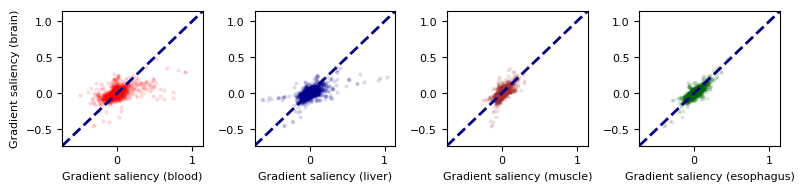

 - (Differential gradient score of brain against 'mean') -


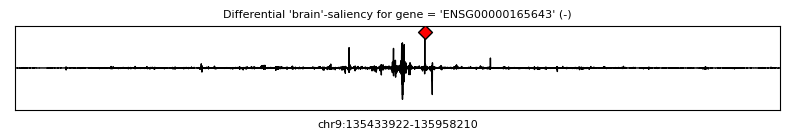

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 280866
 - max_pos (abs) = 135714788
 - chr9:135714692-135714884
blood


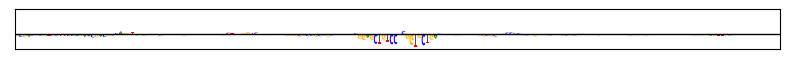

liver


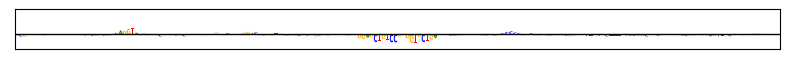

brain


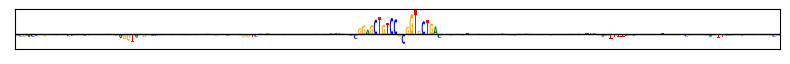

muscle


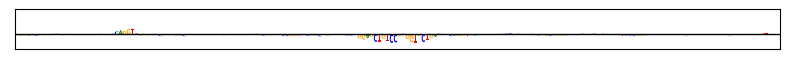

esophagus


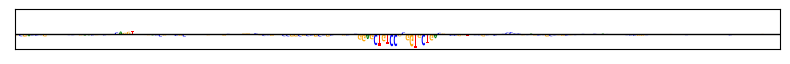

--------------------

-- Example = 2 --
 - ENSG00000188674(-)
 - chr2:207912736-208437024
 -- min_val = -0.944
 -- max_val = 2.223
 - (Gradient score profiles per tissue) - 


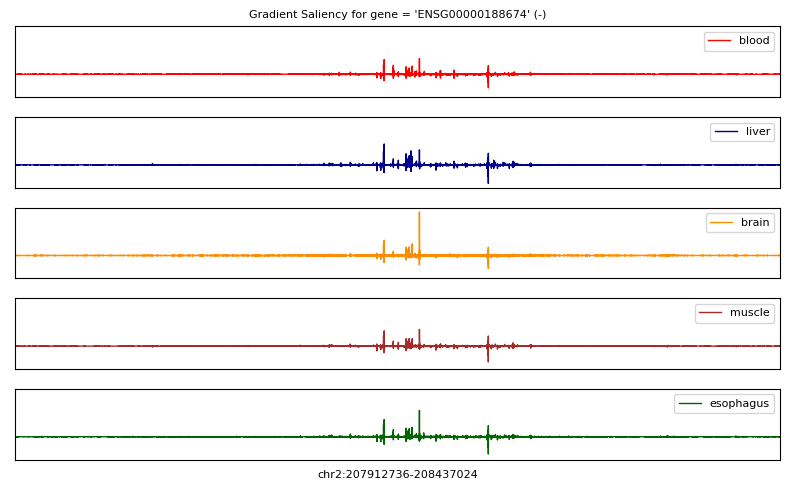

 - (Gradient score comparison against 'brain') - 
blood (r = 0.725)
liver (r = 0.672)
muscle (r = 0.765)
esophagus (r = 0.799)


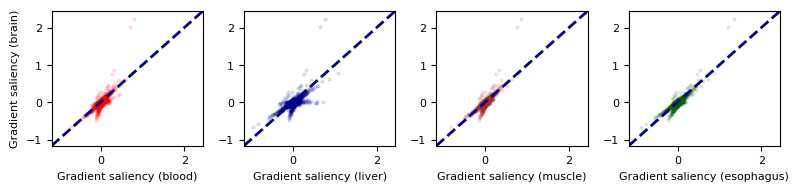

 - (Differential gradient score of brain against 'mean') -


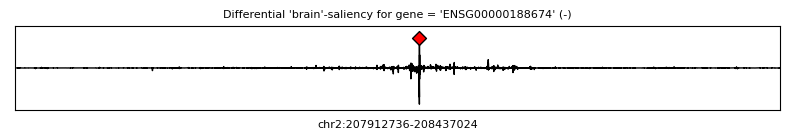

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 277217
 - max_pos (abs) = 208189953
 - chr2:208189857-208190049
blood


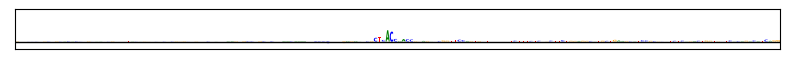

liver


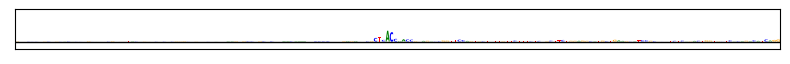

brain


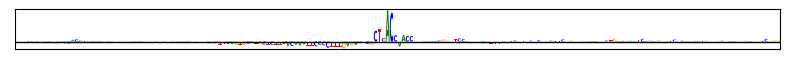

muscle


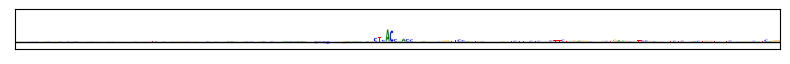

esophagus


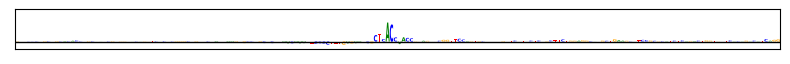

--------------------

-- Example = 3 --
 - ENSG00000022355(+)
 - chr5:161627376-162151664
 -- min_val = -0.4785
 -- max_val = 0.3447
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


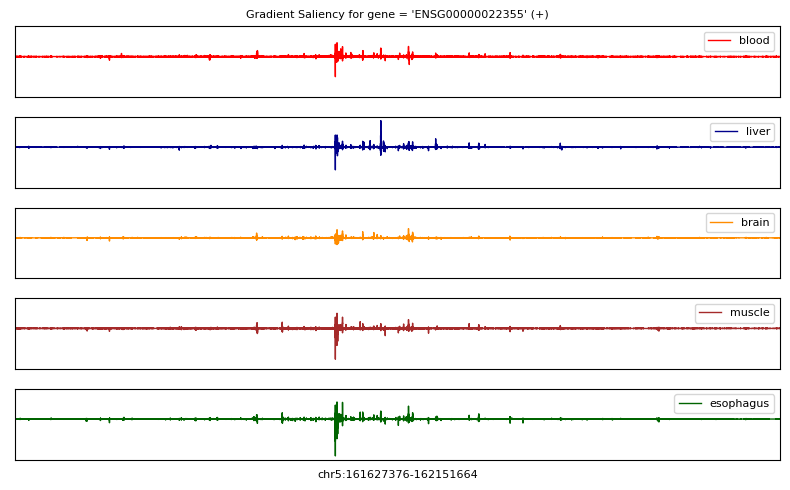

 - (Gradient score comparison against 'brain') - 
blood (r = 0.402)
liver (r = 0.366)
muscle (r = 0.492)
esophagus (r = 0.596)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


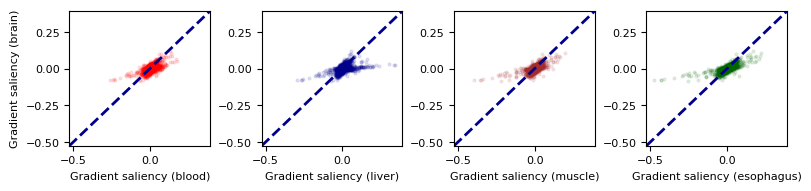

 - (Differential gradient score of brain against 'mean') -


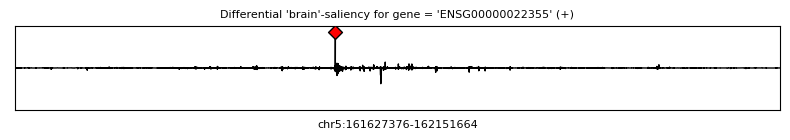

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 219610
 - max_pos (abs) = 161846986
 - chr5:161846890-161847082
blood


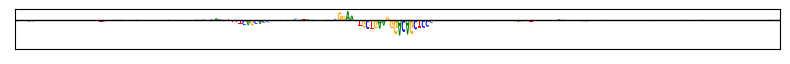

liver


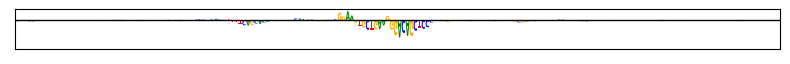

brain


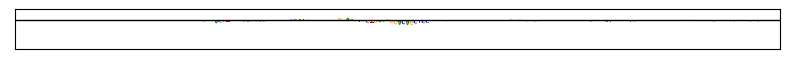

muscle


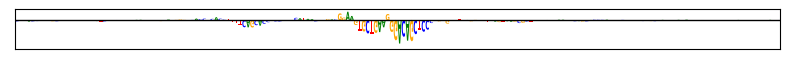

esophagus


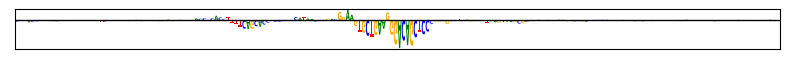

--------------------

-- Example = 4 --
 - ENSG00000164076(-)
 - chr3:49598095-50122383
 -- min_val = -0.7075
 -- max_val = 1.168
 - (Gradient score profiles per tissue) - 


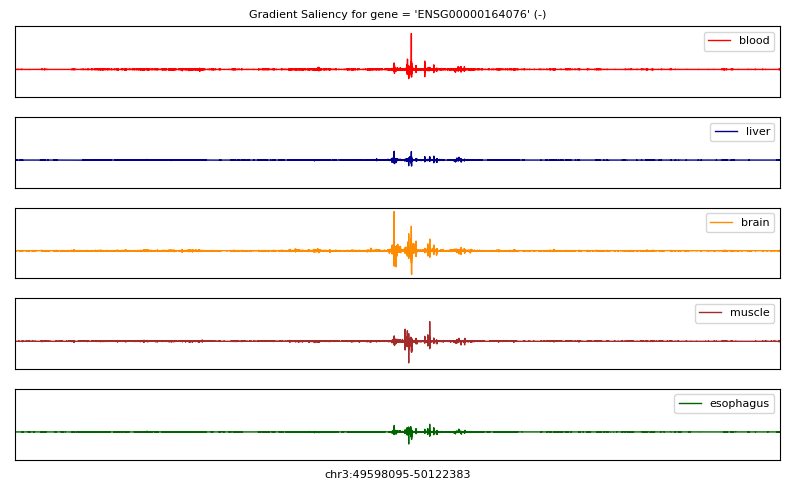

 - (Gradient score comparison against 'brain') - 
blood (r = 0.134)
liver (r = 0.16)
muscle (r = 0.164)
esophagus (r = 0.28)


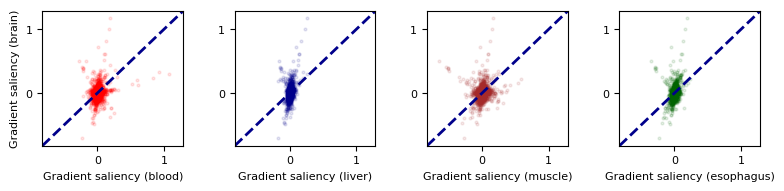

 - (Differential gradient score of brain against 'mean') -


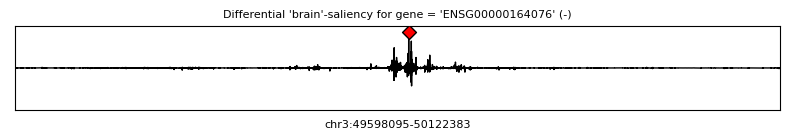

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 269858
 - max_pos (abs) = 49867953
 - chr3:49867857-49868049
blood


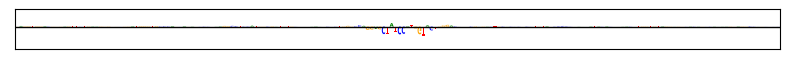

liver


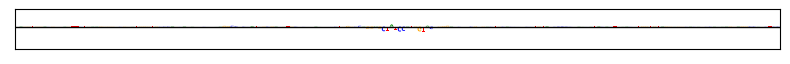

brain


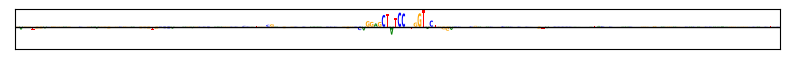

muscle


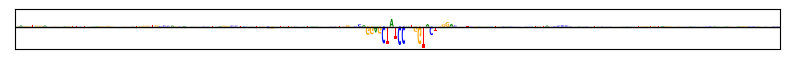

esophagus


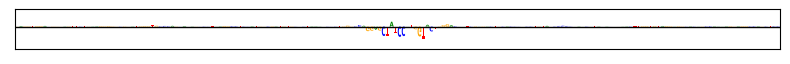

--------------------

-- Example = 5 --
 - ENSG00000136535(+)
 - chr2:161160006-161684294
 -- min_val = -0.2834
 -- max_val = 0.2756
 - (Gradient score profiles per tissue) - 


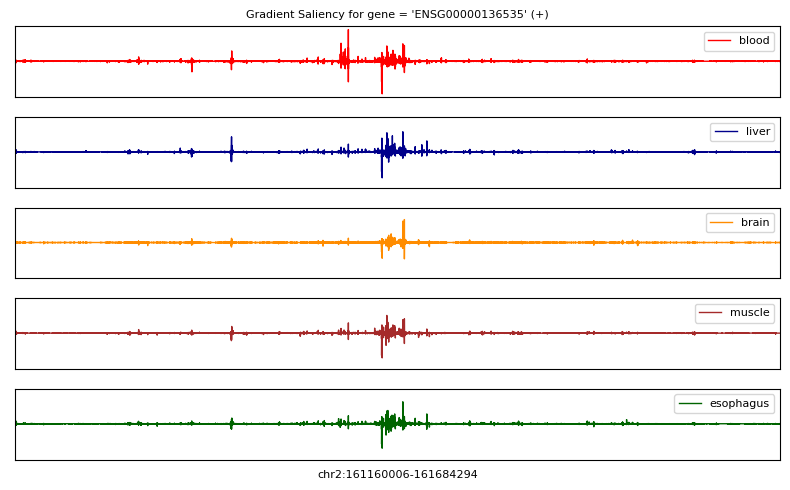

 - (Gradient score comparison against 'brain') - 
blood (r = 0.25)
liver (r = 0.266)
muscle (r = 0.251)
esophagus (r = 0.376)


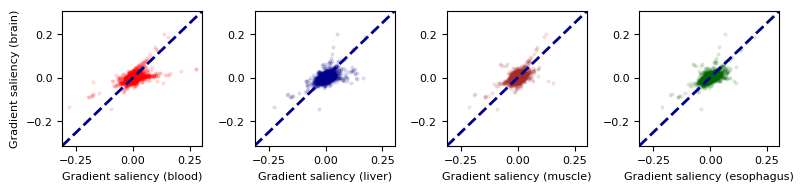

 - (Differential gradient score of brain against 'mean') -


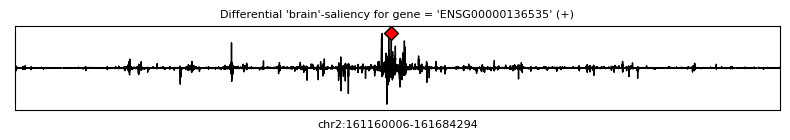

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 257995
 - max_pos (abs) = 161418001
 - chr2:161417905-161418097
blood


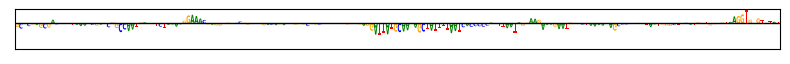

liver


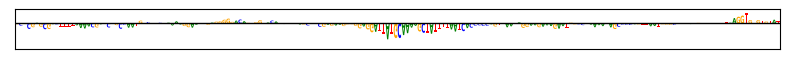

brain


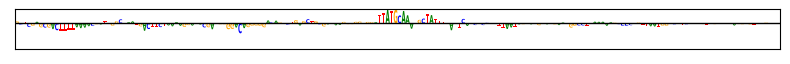

muscle


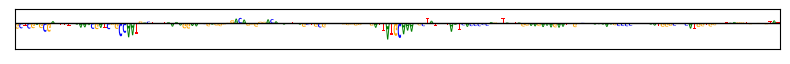

esophagus


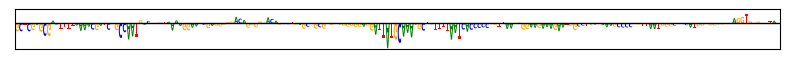

--------------------

-- Example = 6 --
 - ENSG00000176884(+)
 - chr9:136896841-137421129
 -- min_val = -0.4185
 -- max_val = 1.121
 - (Gradient score profiles per tissue) - 


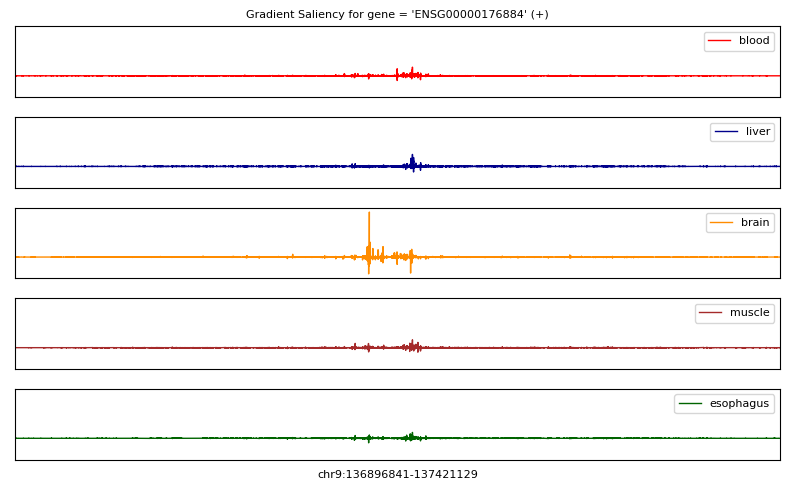

 - (Gradient score comparison against 'brain') - 
blood (r = 0.106)
liver (r = 0.136)
muscle (r = 0.148)
esophagus (r = 0.333)


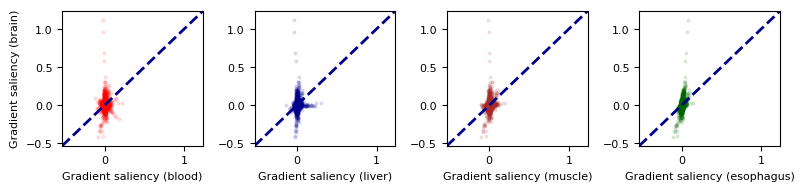

 - (Differential gradient score of brain against 'mean') -


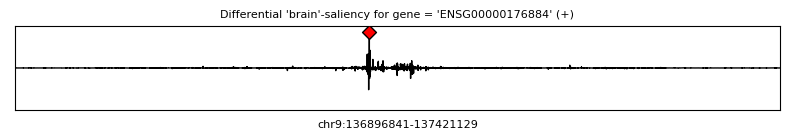

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 242900
 - max_pos (abs) = 137139741
 - chr9:137139645-137139837
blood


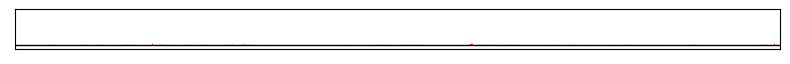

liver


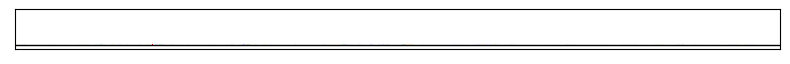

brain


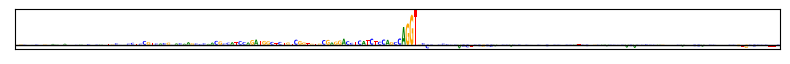

muscle


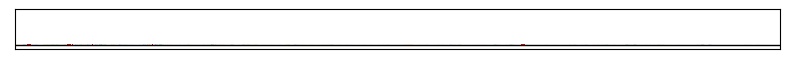

esophagus


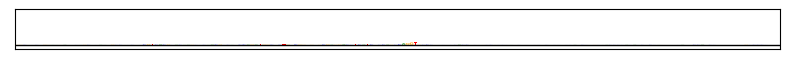

--------------------

-- Example = 7 --
 - ENSG00000162728(+)
 - chr1:159825536-160349824
 -- min_val = -0.3623
 -- max_val = 0.738
 - (Gradient score profiles per tissue) - 


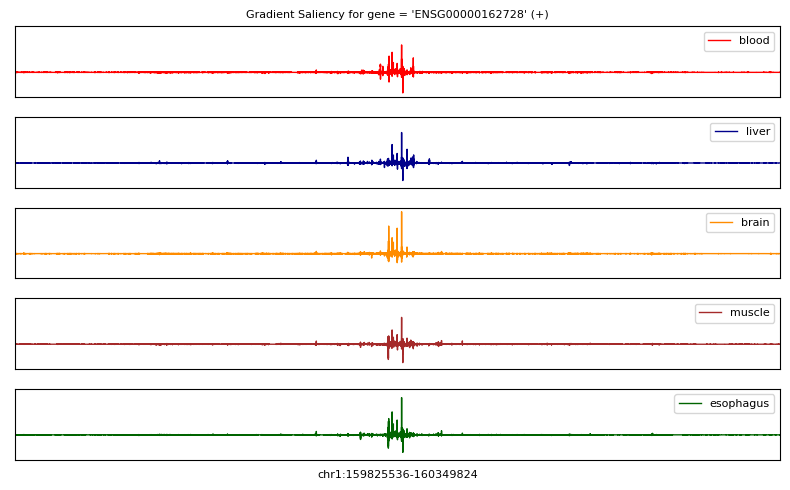

 - (Gradient score comparison against 'brain') - 
blood (r = 0.342)
liver (r = 0.261)
muscle (r = 0.354)
esophagus (r = 0.476)


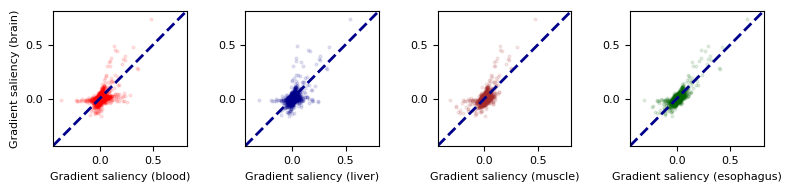

 - (Differential gradient score of brain against 'mean') -


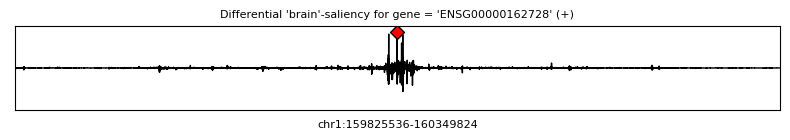

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261953
 - max_pos (abs) = 160087489
 - chr1:160087393-160087585
blood


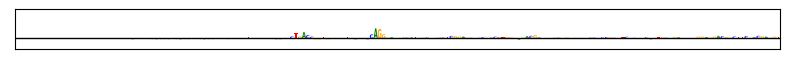

liver


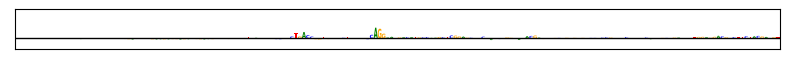

brain


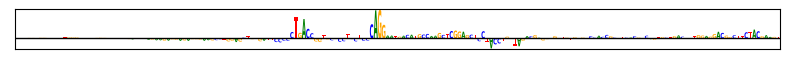

muscle


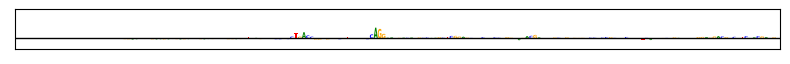

esophagus


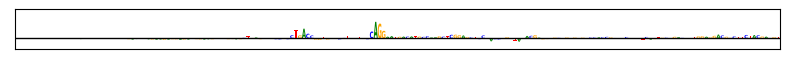

--------------------

-- Example = 8 --
 - ENSG00000130287(+)
 - chr19:18974967-19499255
 -- min_val = -0.3118
 -- max_val = 1.271
 - (Gradient score profiles per tissue) - 


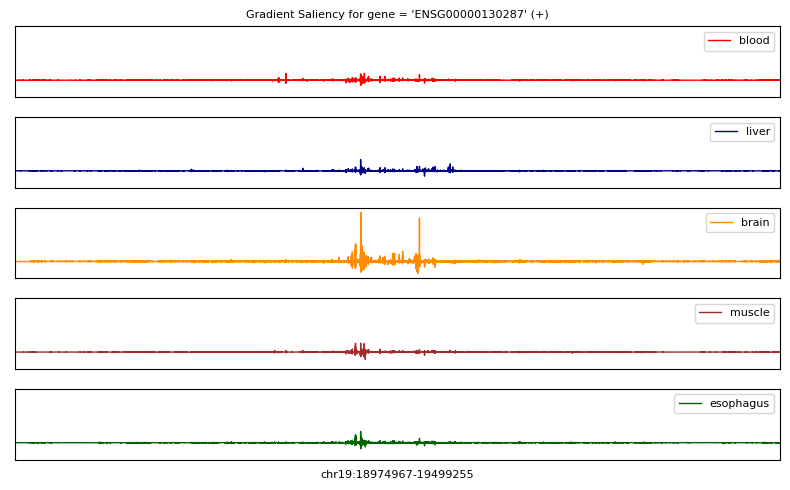

 - (Gradient score comparison against 'brain') - 
blood (r = 0.297)
liver (r = 0.268)
muscle (r = 0.346)
esophagus (r = 0.547)


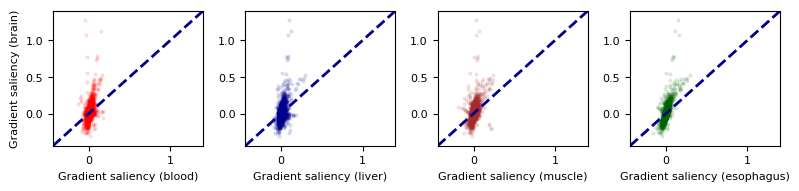

 - (Differential gradient score of brain against 'mean') -


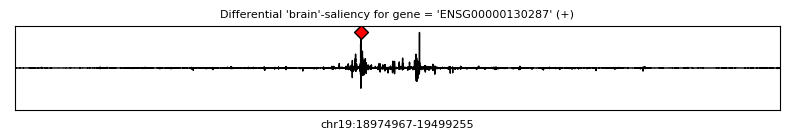

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 237093
 - max_pos (abs) = 19212060
 - chr19:19211964-19212156
blood


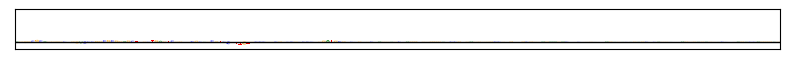

liver


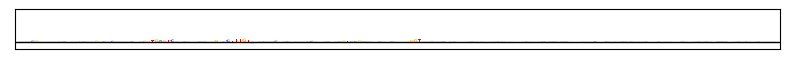

brain


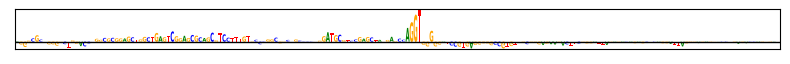

muscle


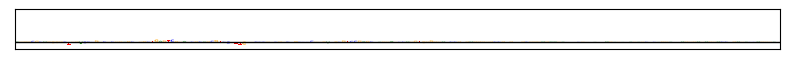

esophagus


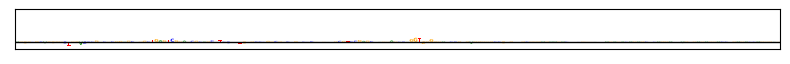

--------------------

-- Example = 9 --
 - ENSG00000164600(-)
 - chr7:31076388-31600676
 -- min_val = -0.753
 -- max_val = 2.021
 - (Gradient score profiles per tissue) - 


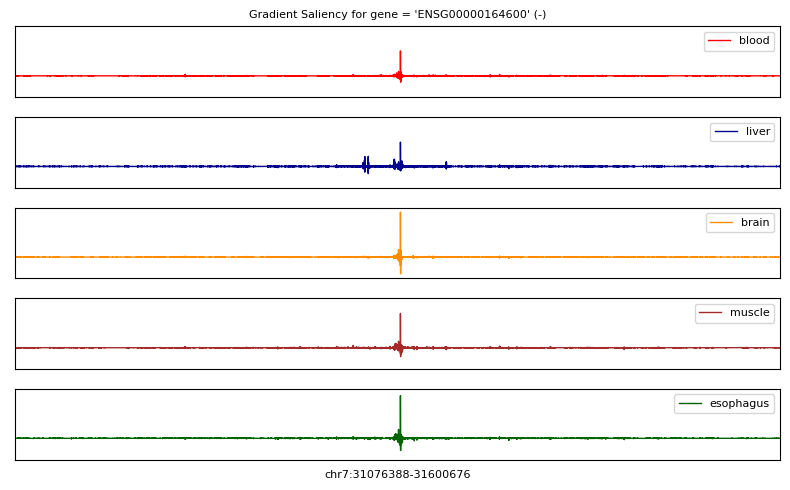

 - (Gradient score comparison against 'brain') - 
blood (r = 0.405)
liver (r = 0.305)
muscle (r = 0.384)
esophagus (r = 0.53)


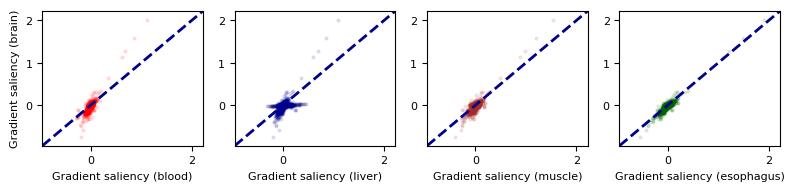

 - (Differential gradient score of brain against 'mean') -


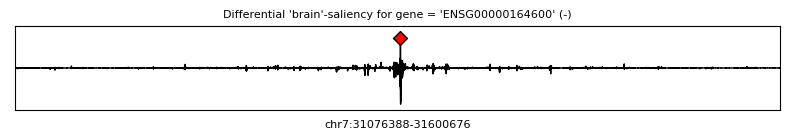

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 264205
 - max_pos (abs) = 31340593
 - chr7:31340497-31340689
blood


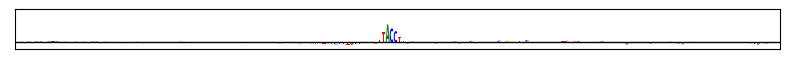

liver


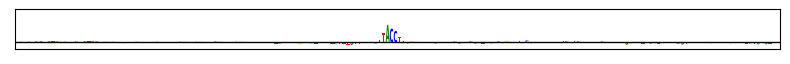

brain


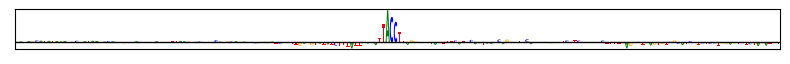

muscle


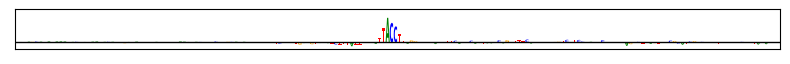

esophagus


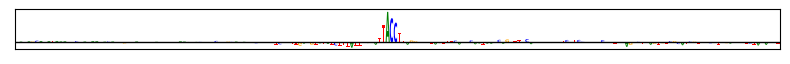

--------------------

-- Example = 10 --
 - ENSG00000197430(-)
 - chr10:96083440-96607728
 -- min_val = -0.703
 -- max_val = 1.051
 - (Gradient score profiles per tissue) - 


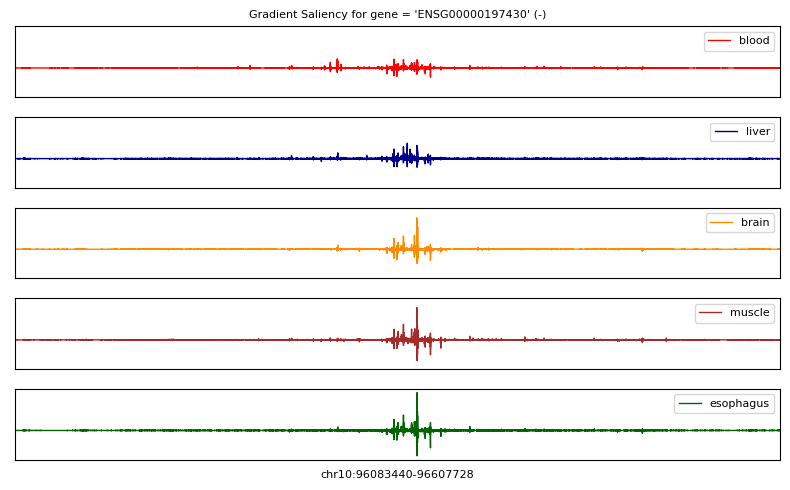

 - (Gradient score comparison against 'brain') - 
blood (r = 0.327)
liver (r = 0.358)
muscle (r = 0.461)
esophagus (r = 0.602)


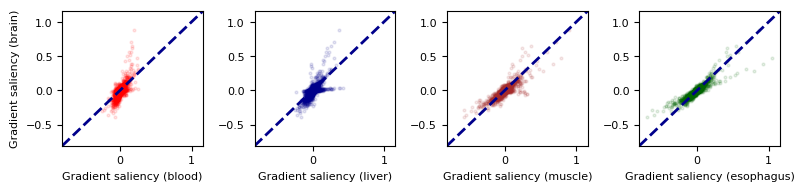

 - (Differential gradient score of brain against 'mean') -


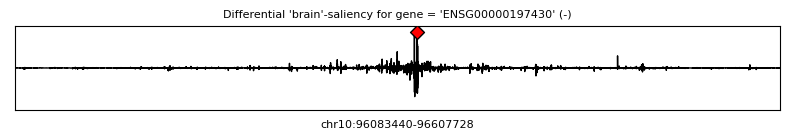

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 275453
 - max_pos (abs) = 96358893
 - chr10:96358797-96358989
blood


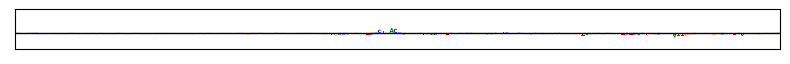

liver


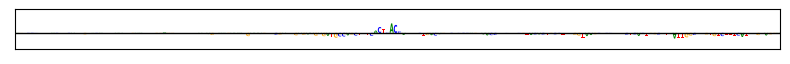

brain


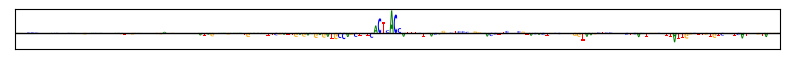

muscle


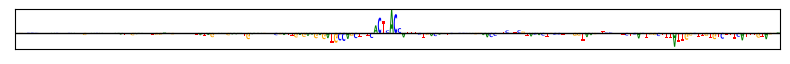

esophagus


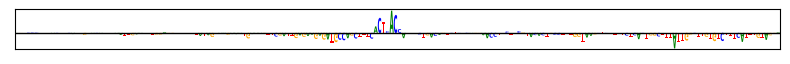

--------------------

-- Example = 11 --
 - ENSG00000198914(+)
 - chr2:104594199-105118487
 -- min_val = -0.354
 -- max_val = 0.9434
 - (Gradient score profiles per tissue) - 


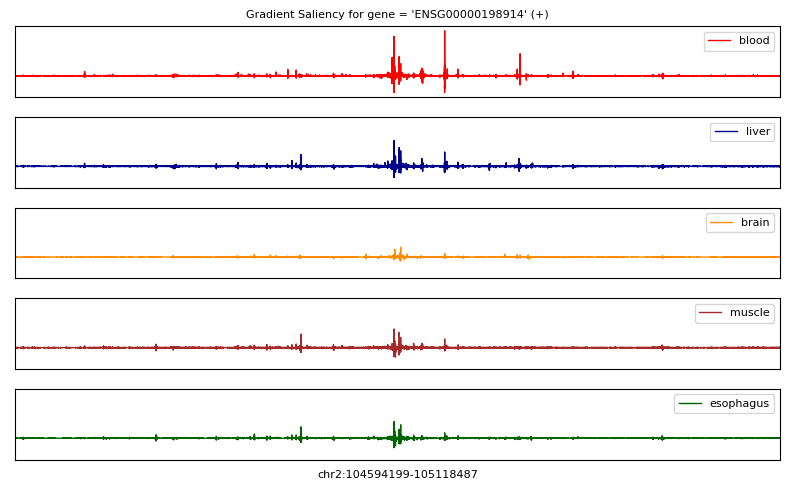

 - (Gradient score comparison against 'brain') - 
blood (r = 0.129)
liver (r = 0.092)
muscle (r = 0.051)
esophagus (r = 0.108)


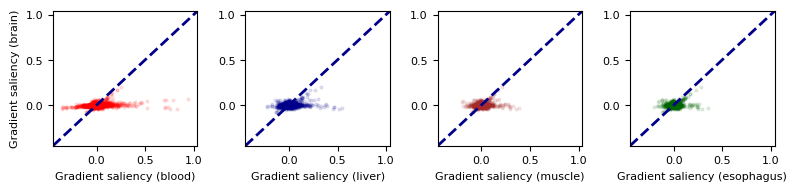

 - (Differential gradient score of brain against 'mean') -


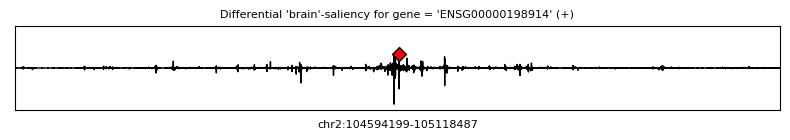

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263301
 - max_pos (abs) = 104857500
 - chr2:104857404-104857596
blood


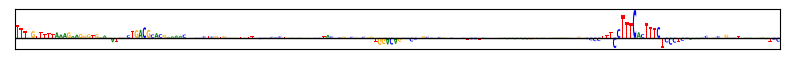

liver


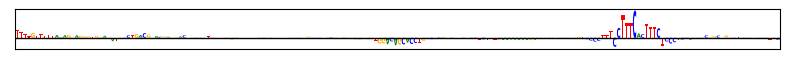

brain


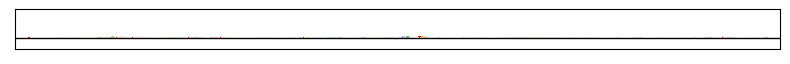

muscle


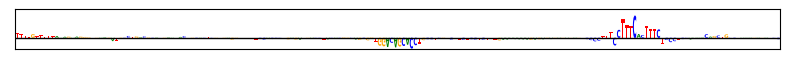

esophagus


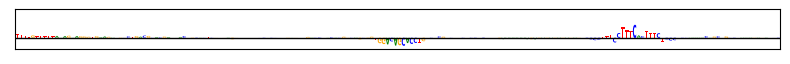

--------------------

-- Example = 12 --
 - ENSG00000127588(-)
 - chr16:536528-1060816
 -- min_val = -0.8105
 -- max_val = 0.4563
 - (Gradient score profiles per tissue) - 


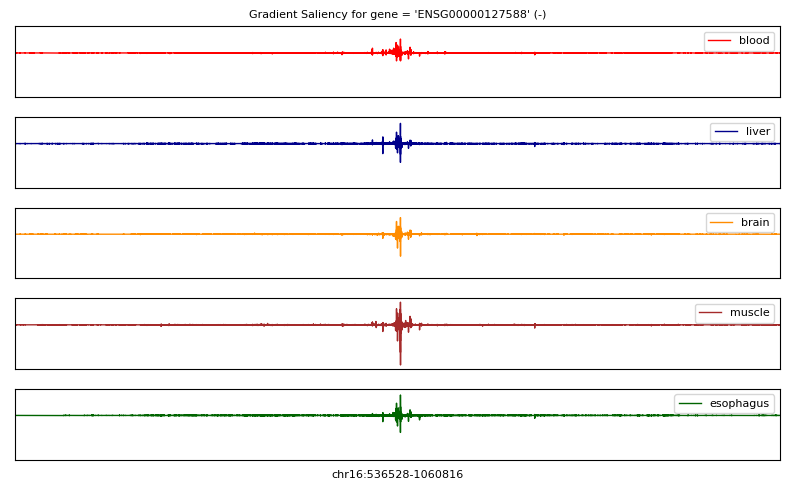

 - (Gradient score comparison against 'brain') - 
blood (r = 0.294)
liver (r = 0.32)
muscle (r = 0.36)
esophagus (r = 0.442)


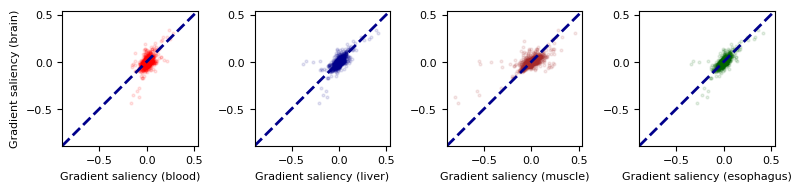

 - (Differential gradient score of brain against 'mean') -


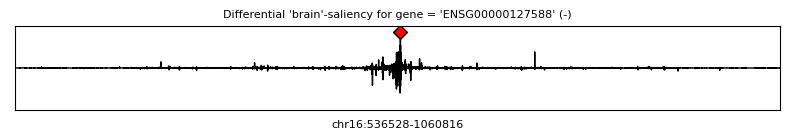

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 264163
 - max_pos (abs) = 800691
 - chr16:800595-800787
blood


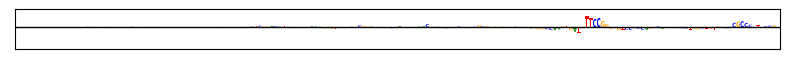

liver


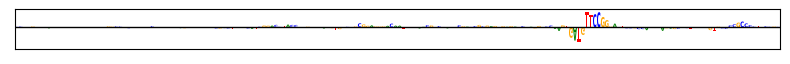

brain


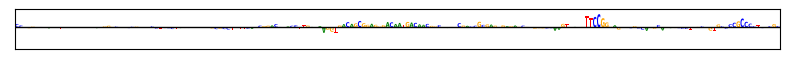

muscle


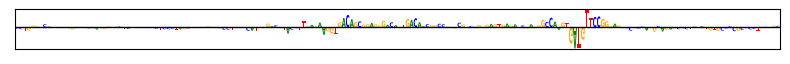

esophagus


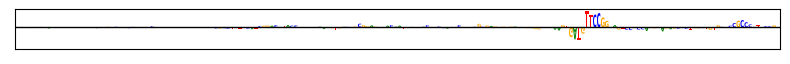

--------------------

-- Example = 13 --
 - ENSG00000124140(+)
 - chr20:45789217-46313505
 -- min_val = -0.2216
 -- max_val = 0.3472
 - (Gradient score profiles per tissue) - 


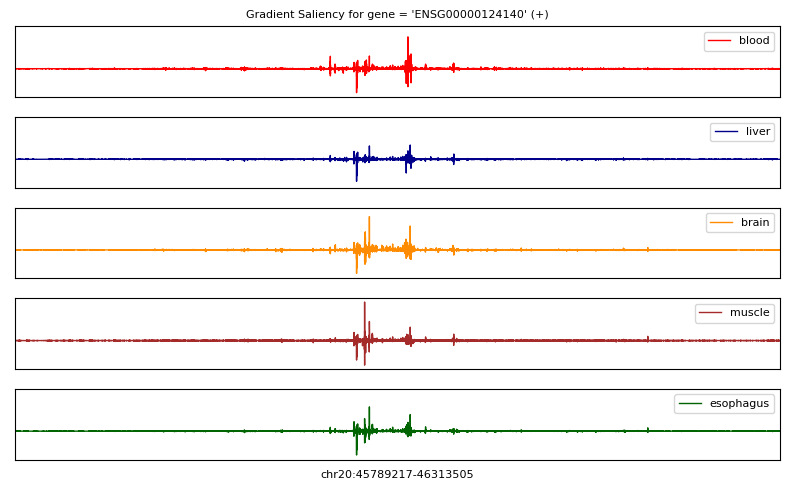

 - (Gradient score comparison against 'brain') - 
blood (r = 0.38)
liver (r = 0.402)
muscle (r = 0.387)
esophagus (r = 0.547)


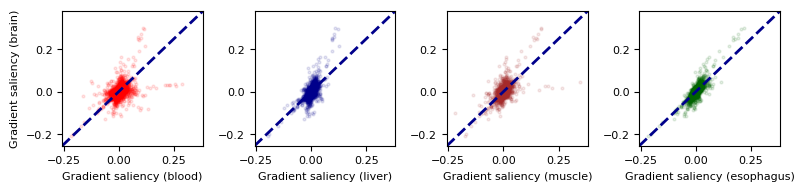

 - (Differential gradient score of brain against 'mean') -


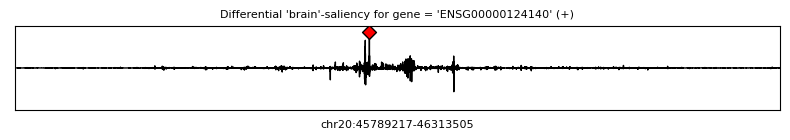

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 242929
 - max_pos (abs) = 46032146
 - chr20:46032050-46032242
blood


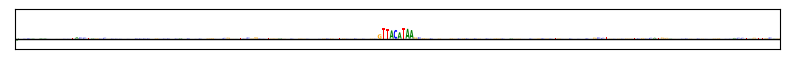

liver


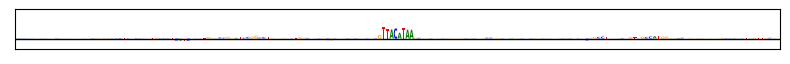

brain


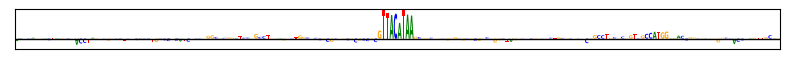

muscle


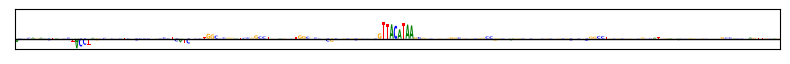

esophagus


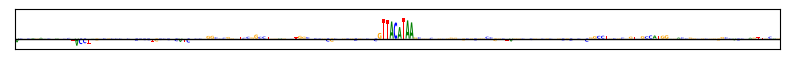

--------------------

-- Example = 14 --
 - ENSG00000136928(-)
 - chr9:98114970-98639258
 -- min_val = -0.214
 -- max_val = 0.3713
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


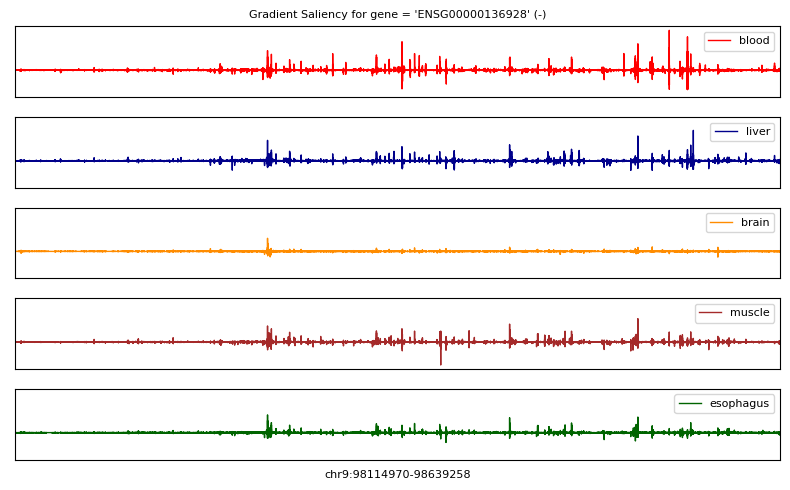

 - (Gradient score comparison against 'brain') - 
blood (r = 0.116)
liver (r = 0.15)
muscle (r = 0.107)
esophagus (r = 0.186)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


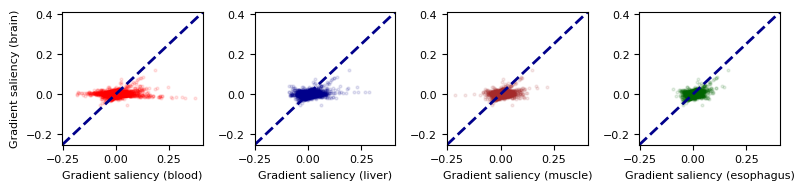

 - (Differential gradient score of brain against 'mean') -


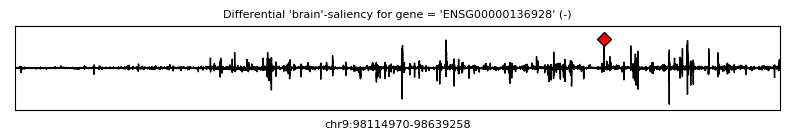

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 403799
 - max_pos (abs) = 98518769
 - chr9:98518673-98518865
blood


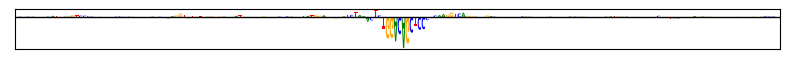

liver


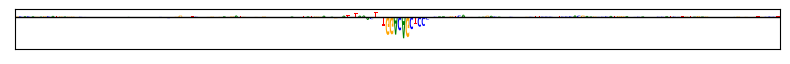

brain


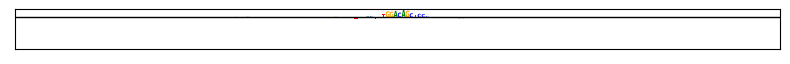

muscle


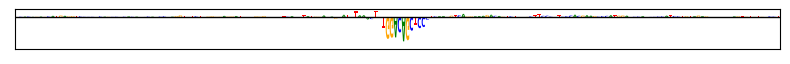

esophagus


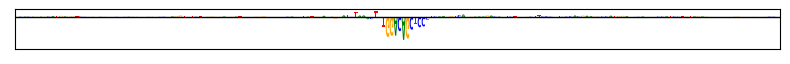

--------------------

-- Example = 15 --
 - ENSG00000105605(+)
 - chr19:53673076-54197364
 -- min_val = -0.2776
 -- max_val = 0.787
 - (Gradient score profiles per tissue) - 


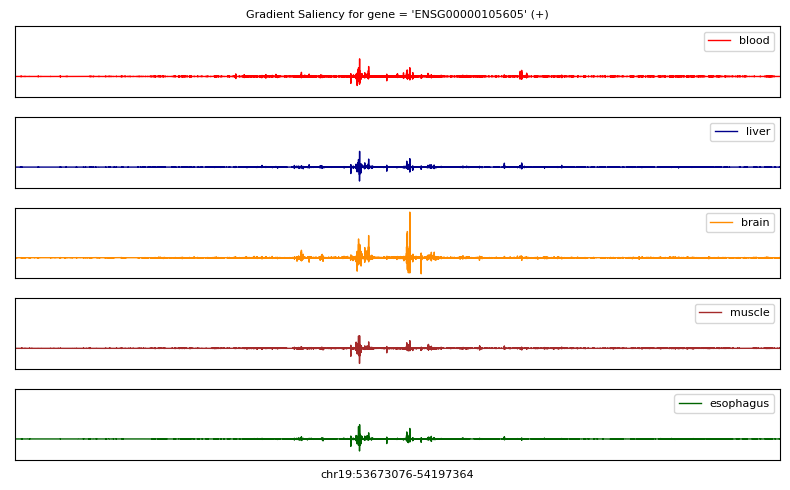

 - (Gradient score comparison against 'brain') - 
blood (r = 0.287)
liver (r = 0.249)
muscle (r = 0.301)
esophagus (r = 0.463)


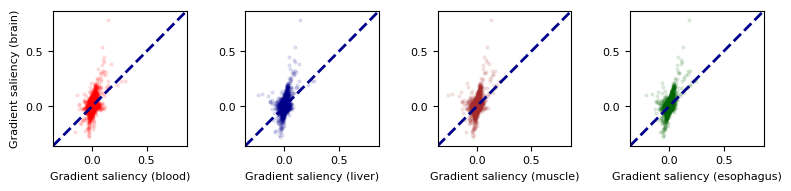

 - (Differential gradient score of brain against 'mean') -


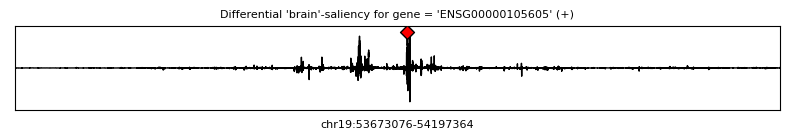

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 268969
 - max_pos (abs) = 53942045
 - chr19:53941949-53942141
blood


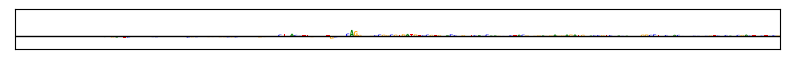

liver


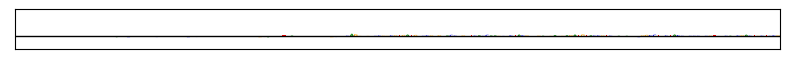

brain


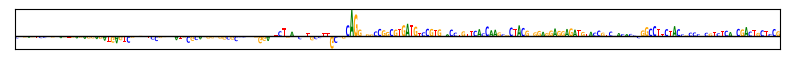

muscle


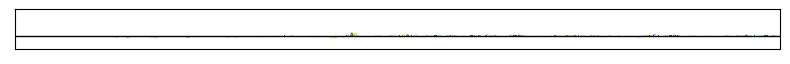

esophagus


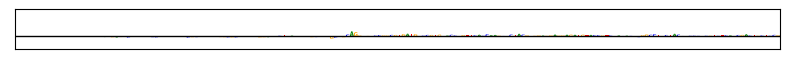

--------------------

-- Example = 16 --
 - ENSG00000075043(-)
 - chr20:63149693-63673981
 -- min_val = -1.635
 -- max_val = 0.5884
 - (Gradient score profiles per tissue) - 


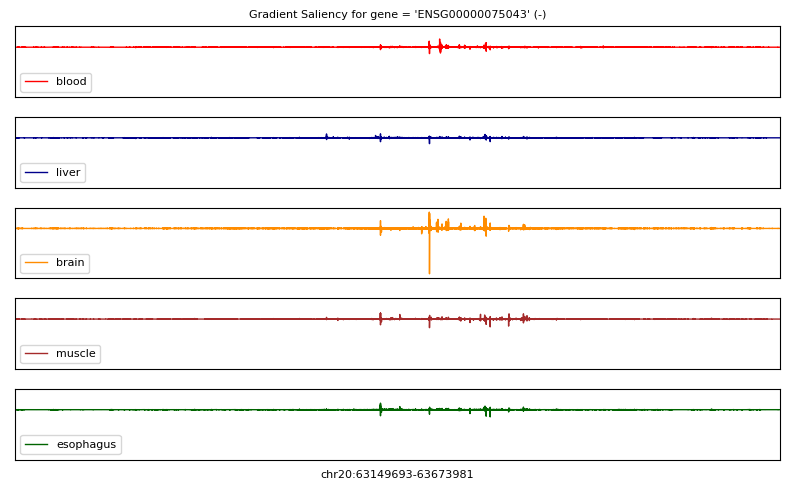

 - (Gradient score comparison against 'brain') - 
blood (r = 0.276)
liver (r = 0.219)
muscle (r = 0.196)
esophagus (r = 0.389)


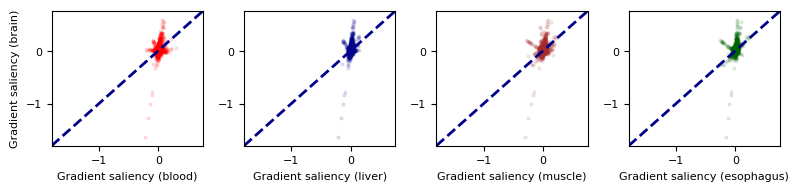

 - (Differential gradient score of brain against 'mean') -


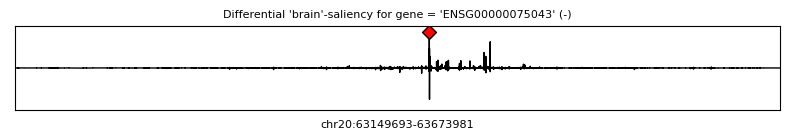

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 283975
 - max_pos (abs) = 63433668
 - chr20:63433572-63433764
blood


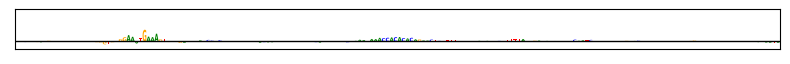

liver


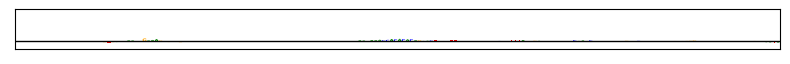

brain


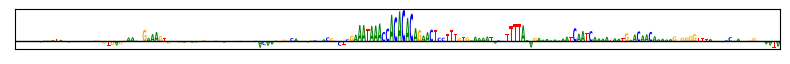

muscle


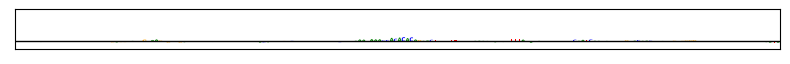

esophagus


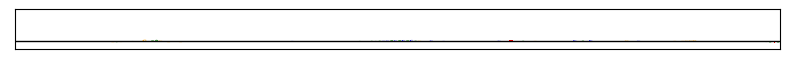

--------------------

-- Example = 17 --
 - ENSG00000141668(-)
 - chr18:72277279-72801567
 -- min_val = -0.1782
 -- max_val = 0.36
 - (Gradient score profiles per tissue) - 


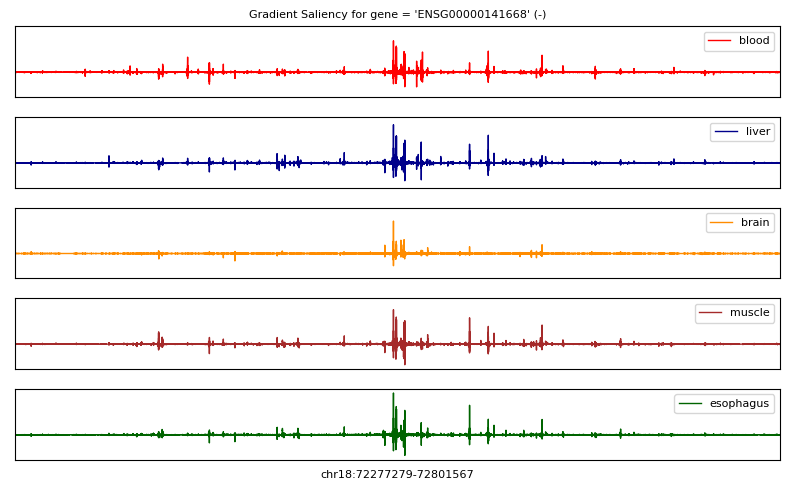

 - (Gradient score comparison against 'brain') - 
blood (r = 0.267)
liver (r = 0.19)
muscle (r = 0.268)
esophagus (r = 0.359)


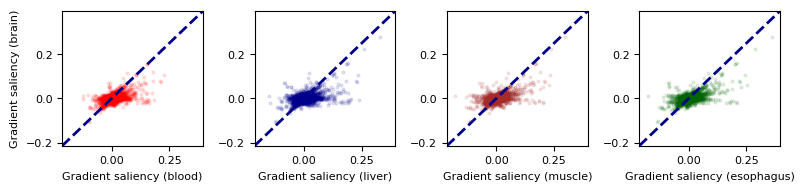

 - (Differential gradient score of brain against 'mean') -


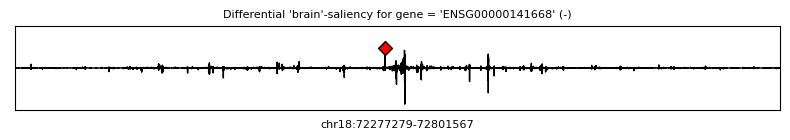

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 253510
 - max_pos (abs) = 72530789
 - chr18:72530693-72530885
blood


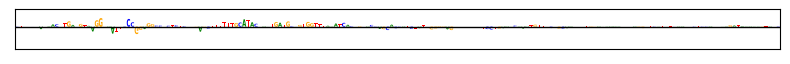

liver


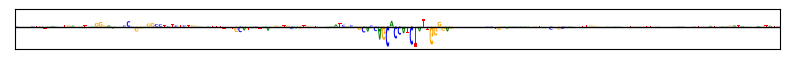

brain


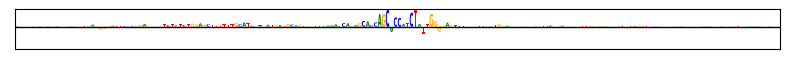

muscle


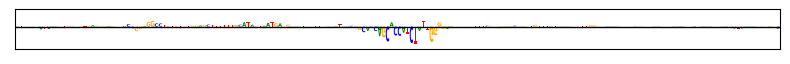

esophagus


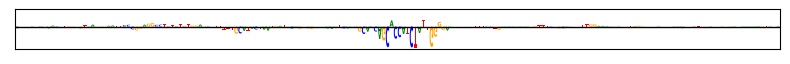

--------------------

-- Example = 18 --
 - ENSG00000011083(+)
 - chr5:149942119-150466407
 -- min_val = -0.4243
 -- max_val = 0.735
 - (Gradient score profiles per tissue) - 


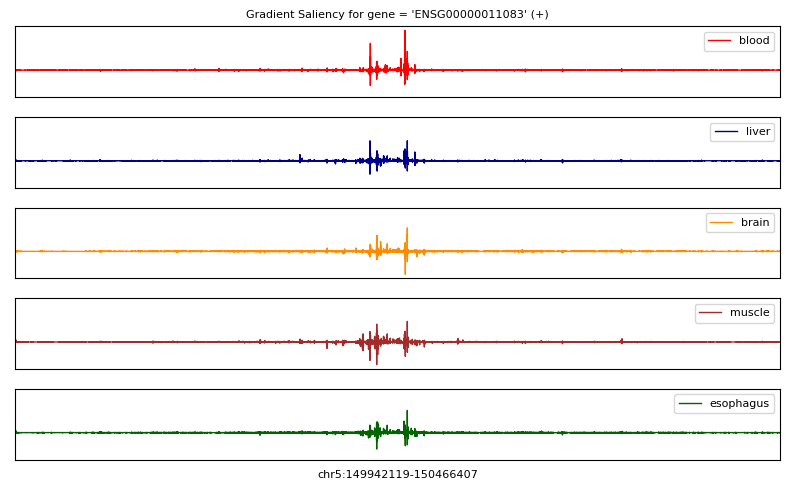

 - (Gradient score comparison against 'brain') - 
blood (r = 0.247)
liver (r = 0.163)
muscle (r = 0.325)
esophagus (r = 0.346)


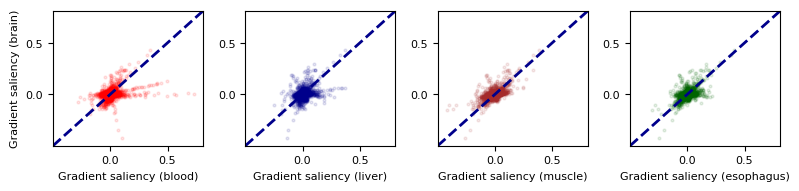

 - (Differential gradient score of brain against 'mean') -


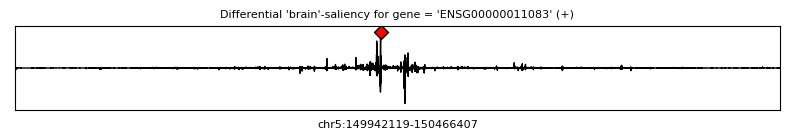

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 250609
 - max_pos (abs) = 150192728
 - chr5:150192632-150192824
blood


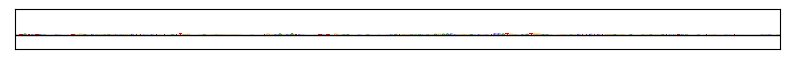

liver


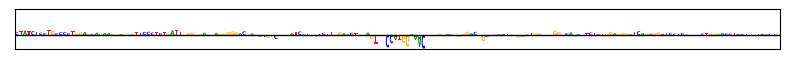

brain


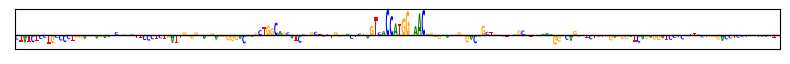

muscle


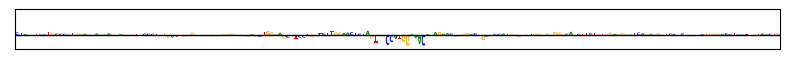

esophagus


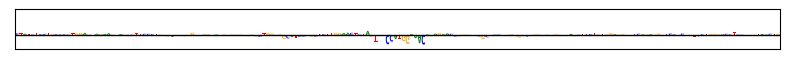

--------------------

-- Example = 19 --
 - ENSG00000273238(-)
 - chr4:312942-837230
 -- min_val = -0.6206
 -- max_val = 0.6055
 - (Gradient score profiles per tissue) - 


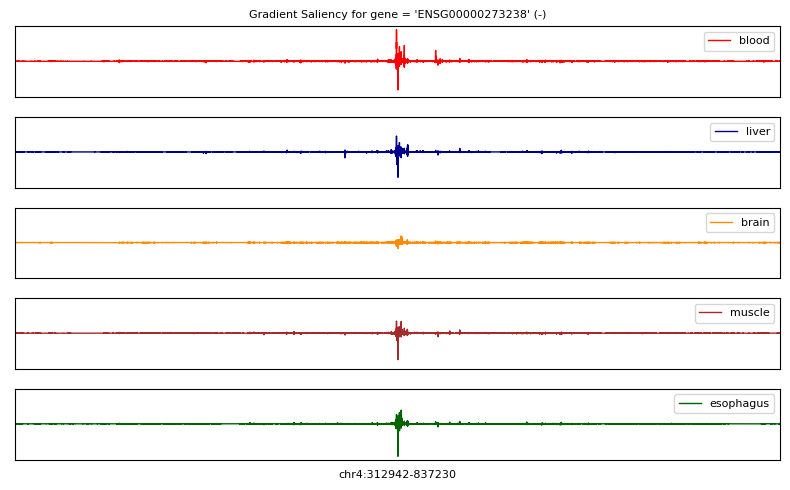

 - (Gradient score comparison against 'brain') - 
blood (r = 0.43)
liver (r = 0.486)
muscle (r = 0.473)
esophagus (r = 0.567)


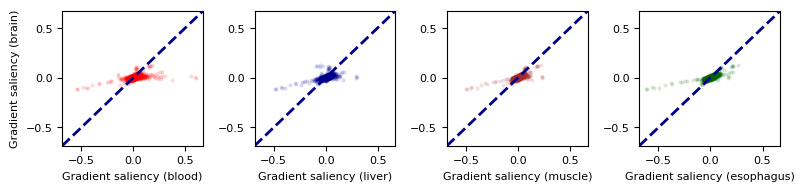

 - (Differential gradient score of brain against 'mean') -


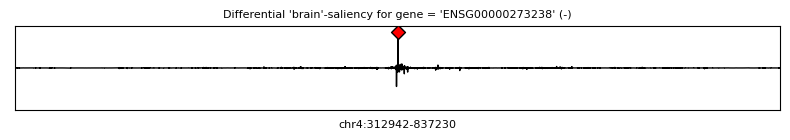

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 262520
 - max_pos (abs) = 575462
 - chr4:575366-575558
blood


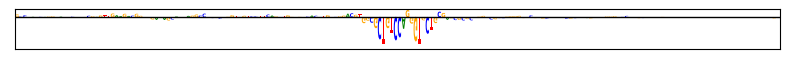

liver


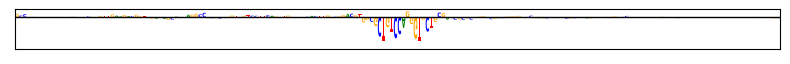

brain


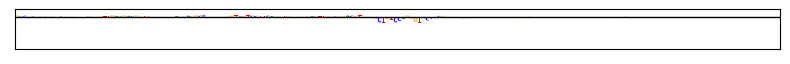

muscle


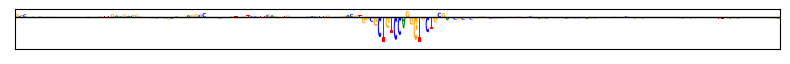

esophagus


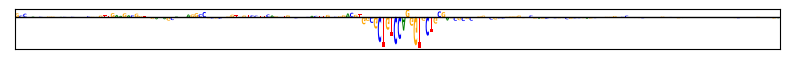

--------------------

-- Example = 20 --
 - ENSG00000152214(-)
 - chr18:42636304-43160592
 -- min_val = -0.5303
 -- max_val = 1.156
 - (Gradient score profiles per tissue) - 


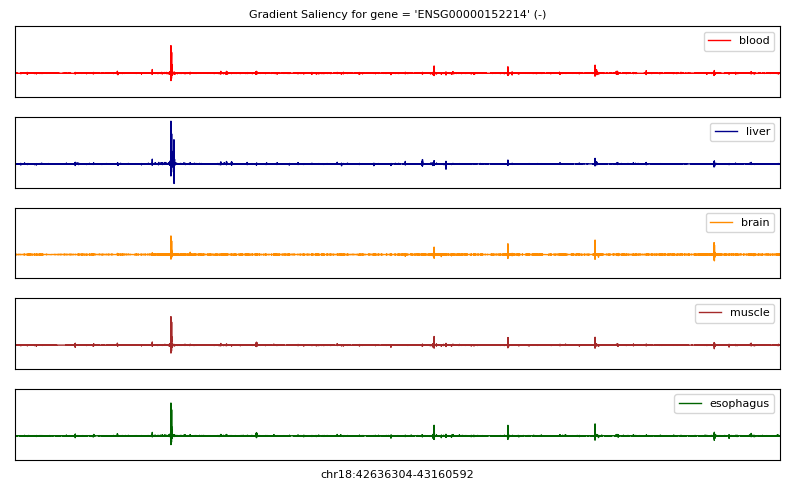

 - (Gradient score comparison against 'brain') - 
blood (r = 0.479)
liver (r = 0.368)
muscle (r = 0.565)
esophagus (r = 0.679)


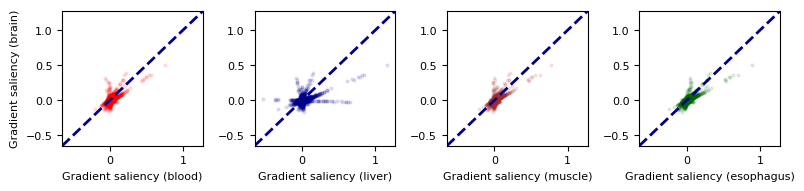

 - (Differential gradient score of brain against 'mean') -


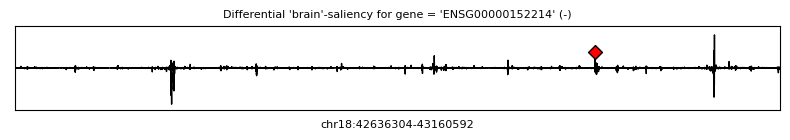

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 397567
 - max_pos (abs) = 43033871
 - chr18:43033775-43033967
blood


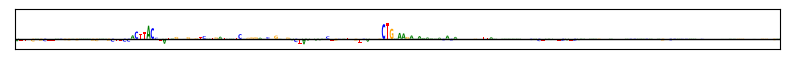

liver


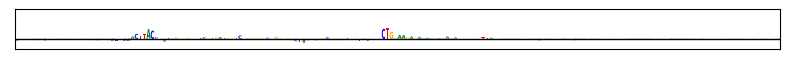

brain


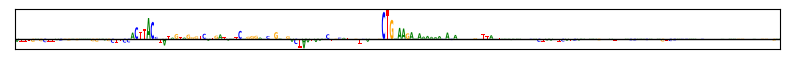

muscle


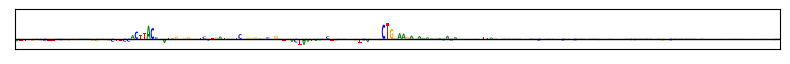

esophagus


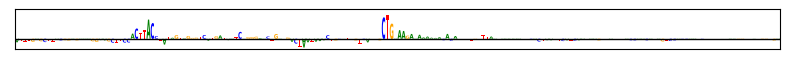

--------------------

-- Example = 21 --
 - ENSG00000185742(+)
 - chr11:109164074-109688362
 -- min_val = -0.453
 -- max_val = 0.7295
 - (Gradient score profiles per tissue) - 


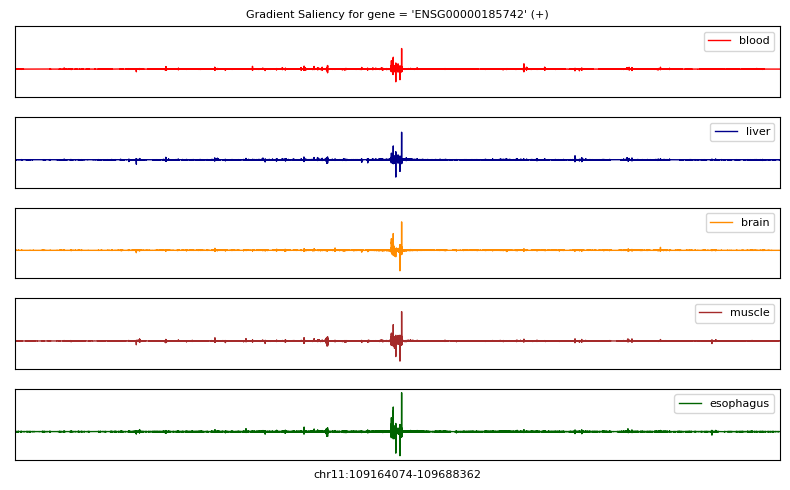

 - (Gradient score comparison against 'brain') - 
blood (r = 0.47)
liver (r = 0.485)
muscle (r = 0.549)
esophagus (r = 0.605)


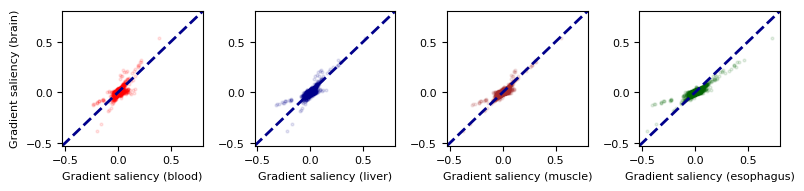

 - (Differential gradient score of brain against 'mean') -


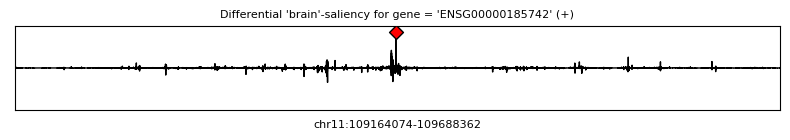

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261017
 - max_pos (abs) = 109425091
 - chr11:109424995-109425187
blood


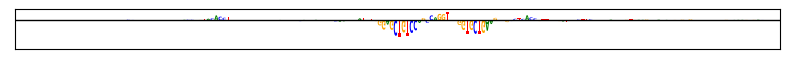

liver


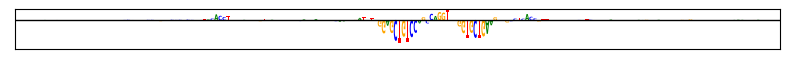

brain


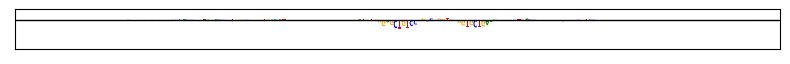

muscle


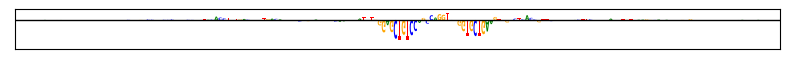

esophagus


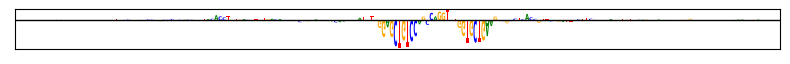

--------------------

-- Example = 22 --
 - ENSG00000126583(+)
 - chr19:53635428-54159716
 -- min_val = -0.4468
 -- max_val = 0.886
 - (Gradient score profiles per tissue) - 


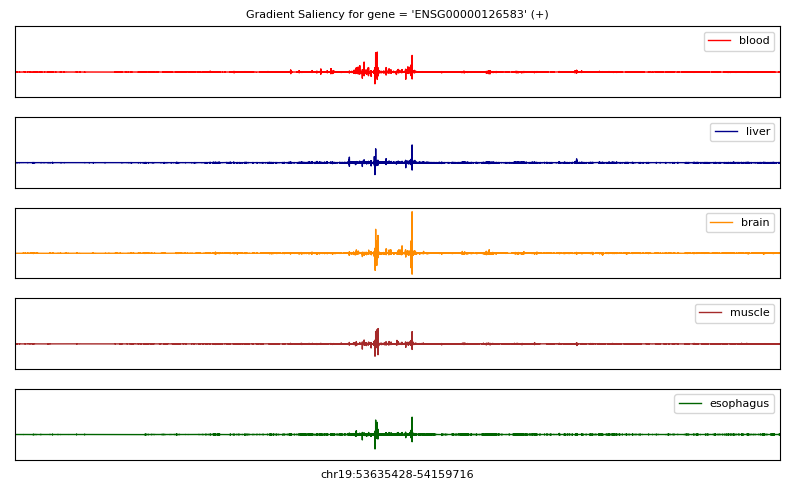

 - (Gradient score comparison against 'brain') - 
blood (r = 0.252)
liver (r = 0.197)
muscle (r = 0.24)
esophagus (r = 0.382)


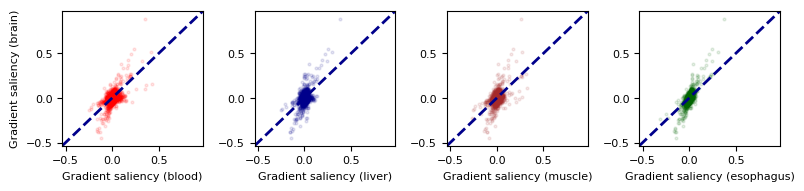

 - (Differential gradient score of brain against 'mean') -


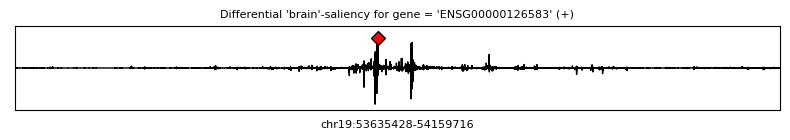

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 248815
 - max_pos (abs) = 53884243
 - chr19:53884147-53884339
blood


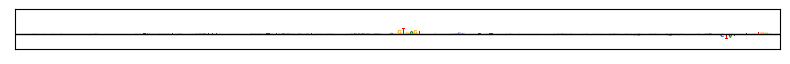

liver


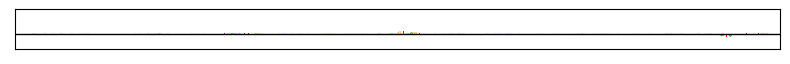

brain


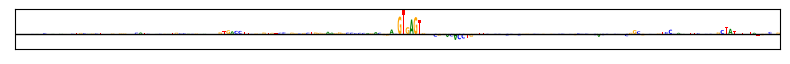

muscle


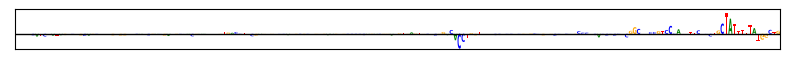

esophagus


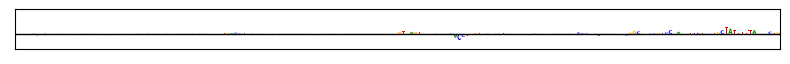

--------------------

-- Example = 23 --
 - ENSG00000171532(-)
 - chr17:39343209-39867497
 -- min_val = -0.1685
 -- max_val = 0.4524
 - (Gradient score profiles per tissue) - 


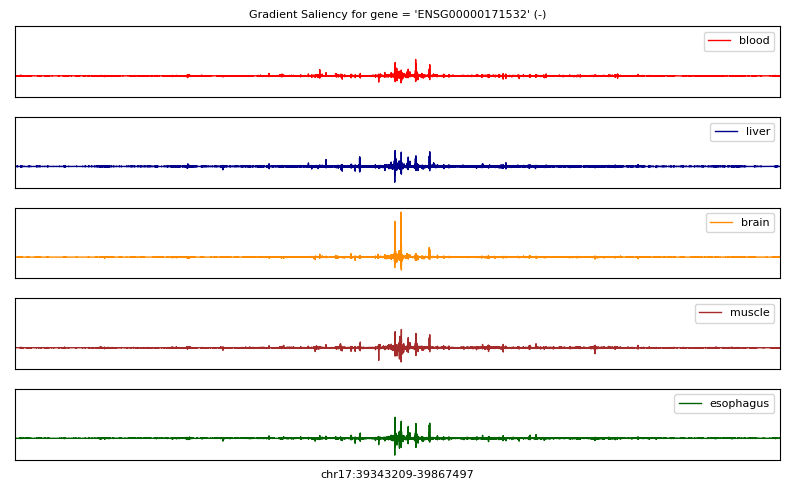

 - (Gradient score comparison against 'brain') - 
blood (r = 0.349)
liver (r = 0.36)
muscle (r = 0.315)
esophagus (r = 0.519)


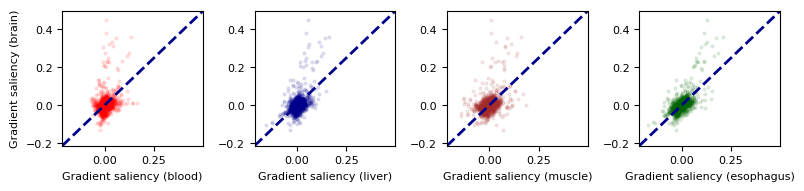

 - (Differential gradient score of brain against 'mean') -


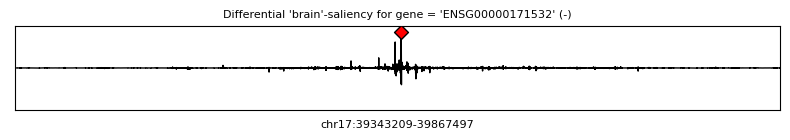

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 264756
 - max_pos (abs) = 39607965
 - chr17:39607869-39608061
blood


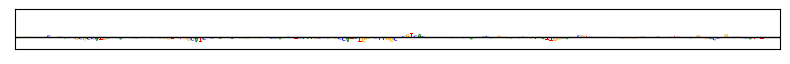

liver


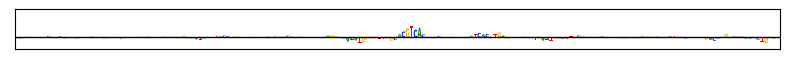

brain


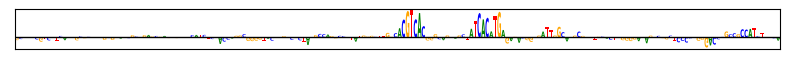

muscle


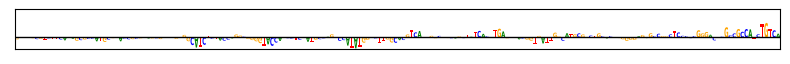

esophagus


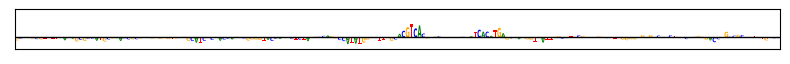

--------------------

-- Example = 24 --
 - ENSG00000261678(-)
 - chr8:144070617-144594905
 -- min_val = -0.5093
 -- max_val = 0.635
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


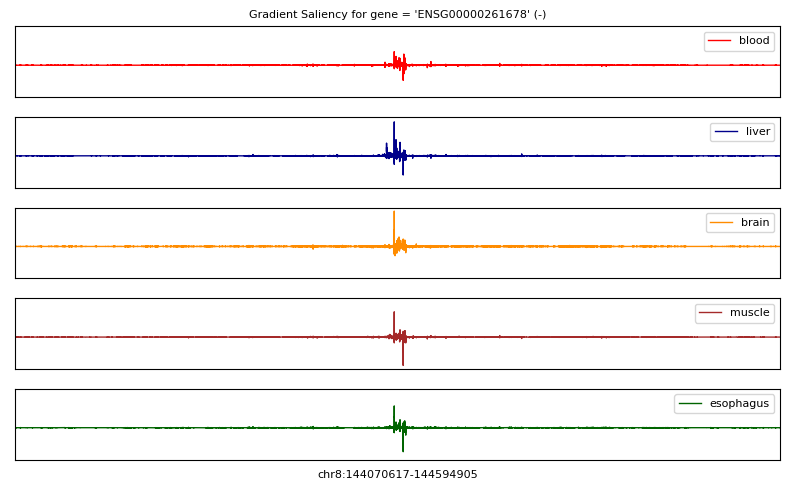

 - (Gradient score comparison against 'brain') - 
blood (r = 0.103)
liver (r = 0.048)
muscle (r = 0.11)
esophagus (r = 0.239)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


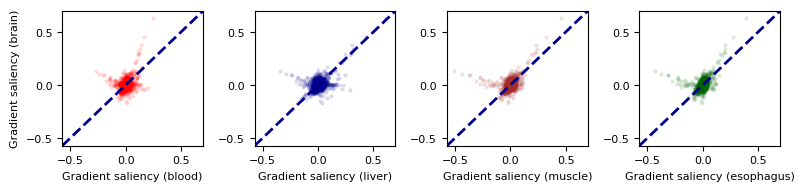

 - (Differential gradient score of brain against 'mean') -


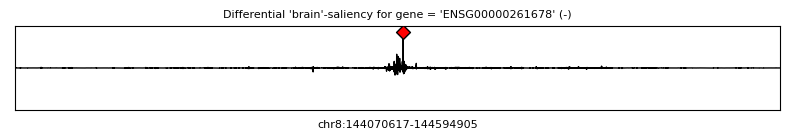

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 266099
 - max_pos (abs) = 144336716
 - chr8:144336620-144336812
blood


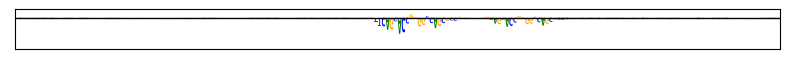

liver


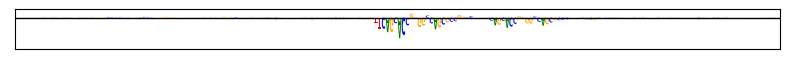

brain


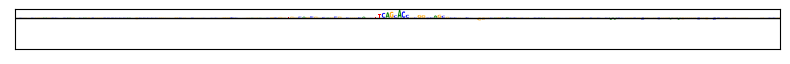

muscle


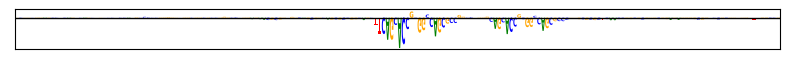

esophagus


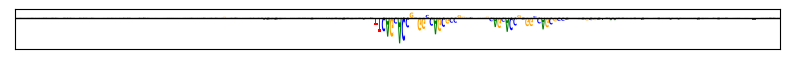

--------------------

-- Example = 25 --
 - ENSG00000187135(+)
 - chr19:29278100-29802388
 -- min_val = -0.1852
 -- max_val = 0.322
 - (Gradient score profiles per tissue) - 


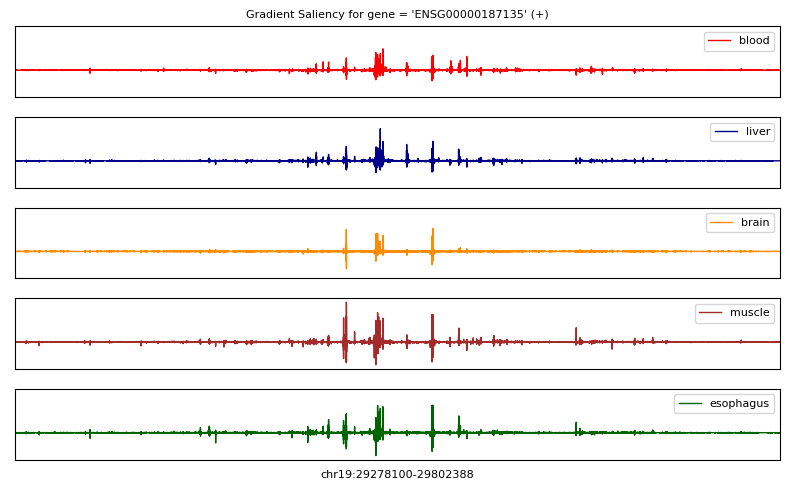

 - (Gradient score comparison against 'brain') - 
blood (r = 0.396)
liver (r = 0.388)
muscle (r = 0.409)
esophagus (r = 0.486)


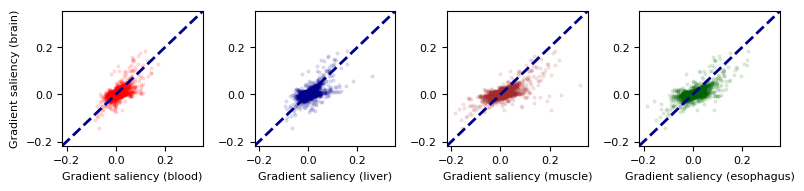

 - (Differential gradient score of brain against 'mean') -


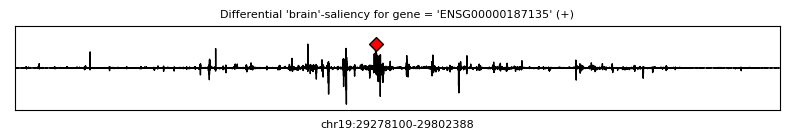

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 247368
 - max_pos (abs) = 29525468
 - chr19:29525372-29525564
blood


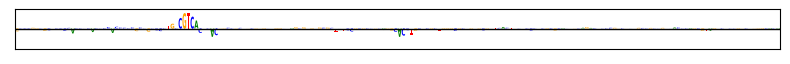

liver


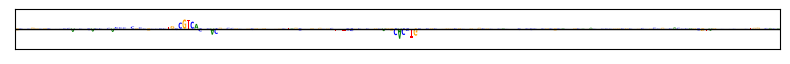

brain


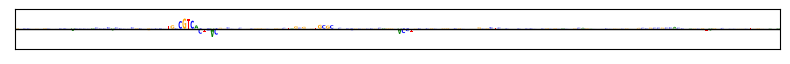

muscle


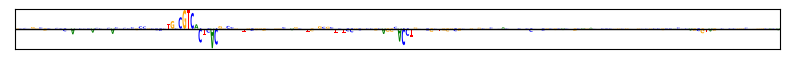

esophagus


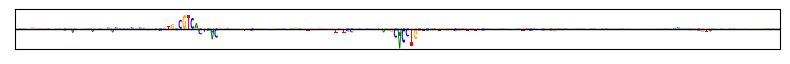

--------------------

-- Example = 26 --
 - ENSG00000166159(+)
 - chr12:1570970-2095258
 -- min_val = -0.9966
 -- max_val = 0.7188
 - (Gradient score profiles per tissue) - 


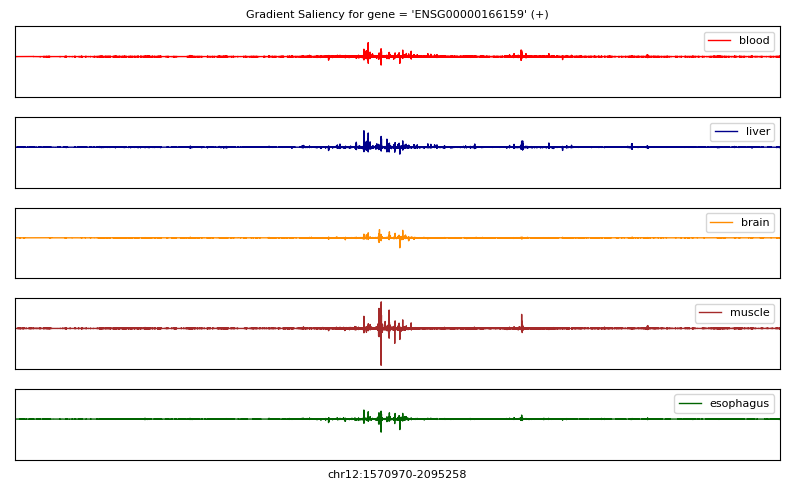

 - (Gradient score comparison against 'brain') - 
blood (r = 0.306)
liver (r = 0.227)
muscle (r = 0.255)
esophagus (r = 0.469)


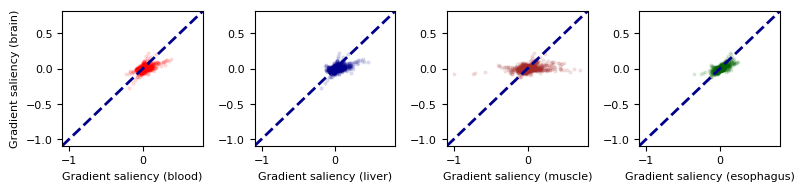

 - (Differential gradient score of brain against 'mean') -


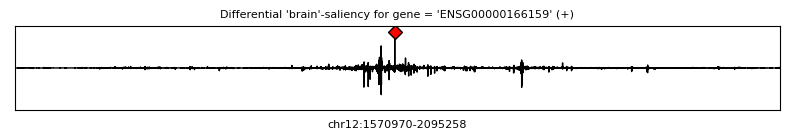

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 260288
 - max_pos (abs) = 1831258
 - chr12:1831162-1831354
blood


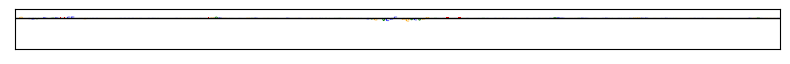

liver


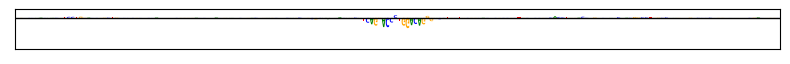

brain


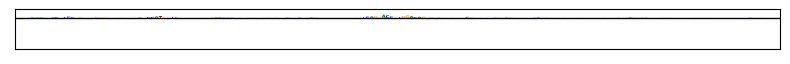

muscle


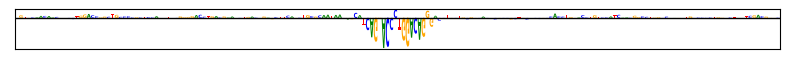

esophagus


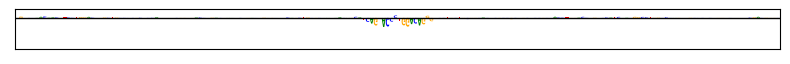

--------------------

-- Example = 27 --
 - ENSG00000154975(-)
 - chr17:51565085-52089373
 -- min_val = -0.2861
 -- max_val = 0.6094
 - (Gradient score profiles per tissue) - 


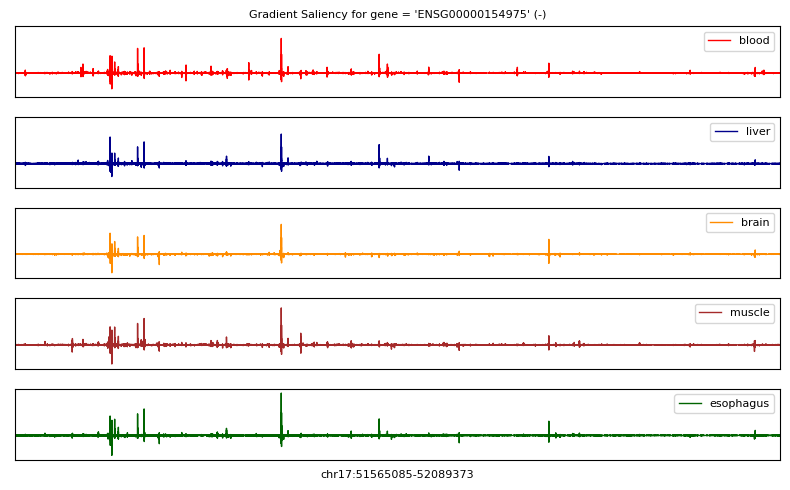

 - (Gradient score comparison against 'brain') - 
blood (r = 0.408)
liver (r = 0.437)
muscle (r = 0.396)
esophagus (r = 0.553)


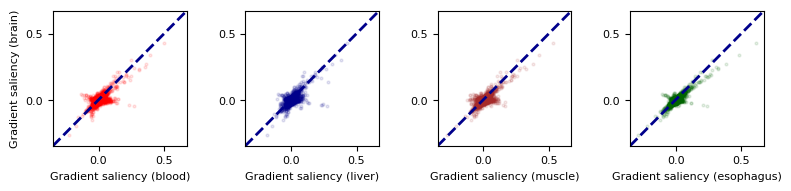

 - (Differential gradient score of brain against 'mean') -


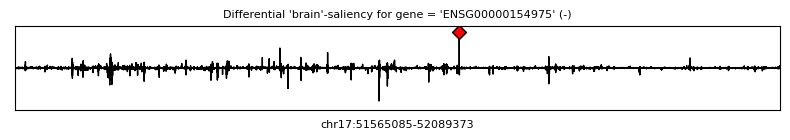

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 304492
 - max_pos (abs) = 51869577
 - chr17:51869481-51869673
blood


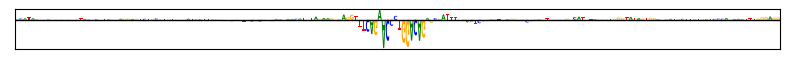

liver


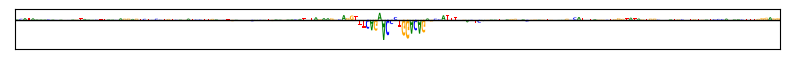

brain


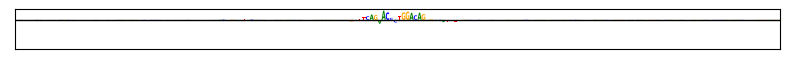

muscle


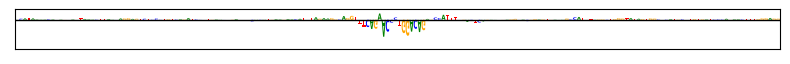

esophagus


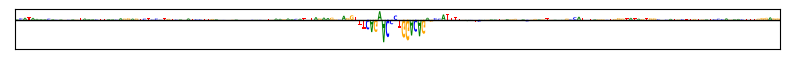

--------------------

-- Example = 28 --
 - ENSG00000153266(-)
 - chr3:62109546-62633834
 -- min_val = -0.5215
 -- max_val = 0.7197
 - (Gradient score profiles per tissue) - 


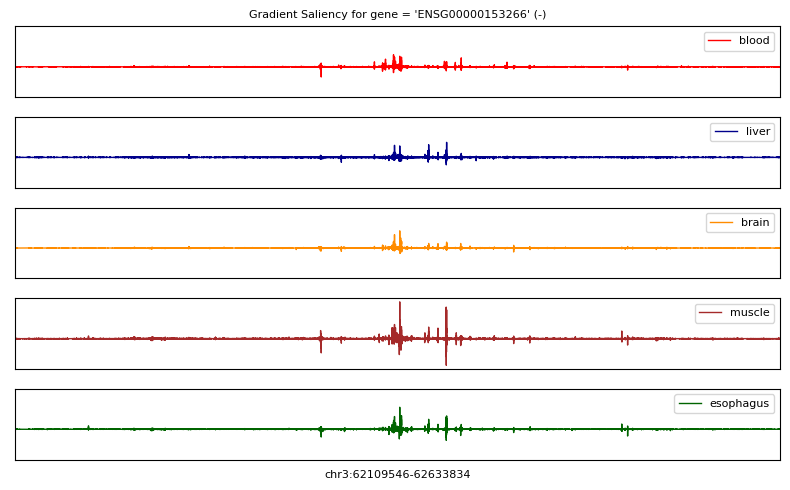

 - (Gradient score comparison against 'brain') - 
blood (r = 0.32)
liver (r = 0.314)
muscle (r = 0.27)
esophagus (r = 0.328)


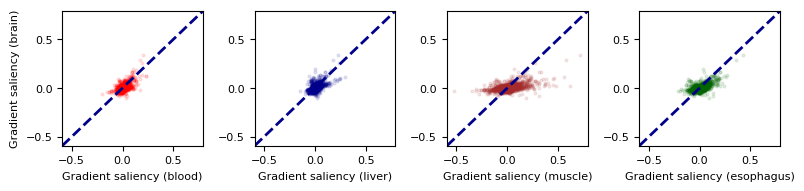

 - (Differential gradient score of brain against 'mean') -


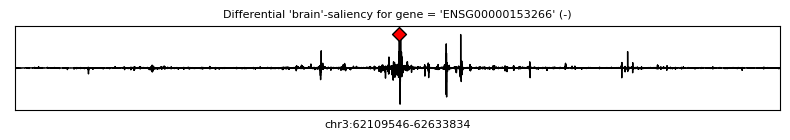

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263454
 - max_pos (abs) = 62373000
 - chr3:62372904-62373096
blood


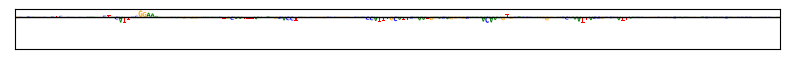

liver


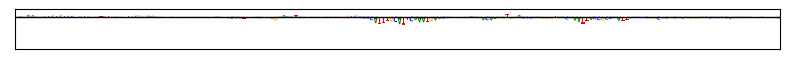

brain


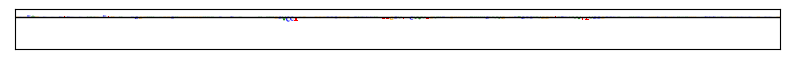

muscle


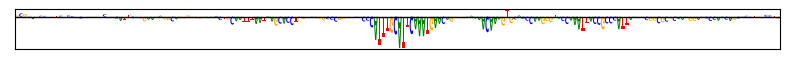

esophagus


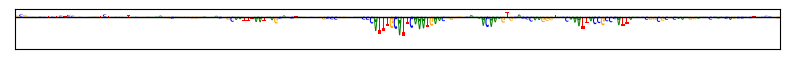

--------------------

-- Example = 29 --
 - ENSG00000101438(+)
 - chr20:38465376-38989664
 -- min_val = -0.2578
 -- max_val = 0.321
 - (Gradient score profiles per tissue) - 


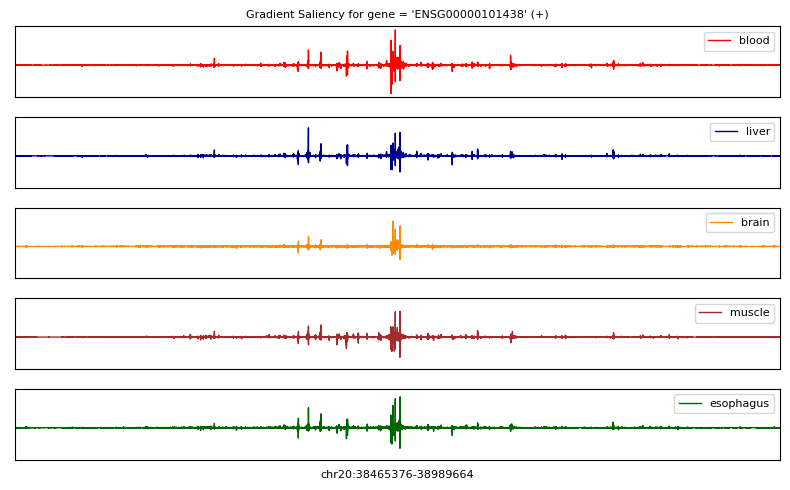

 - (Gradient score comparison against 'brain') - 
blood (r = 0.418)
liver (r = 0.399)
muscle (r = 0.329)
esophagus (r = 0.566)


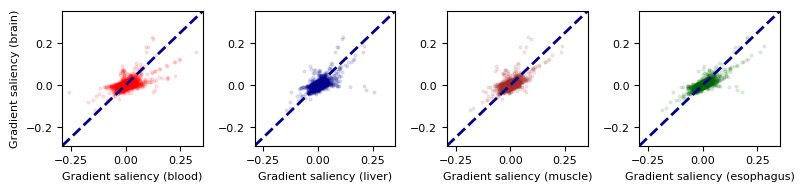

 - (Differential gradient score of brain against 'mean') -


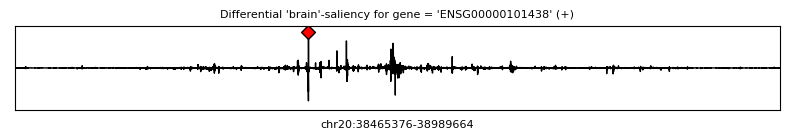

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 201191
 - max_pos (abs) = 38666567
 - chr20:38666471-38666663
blood


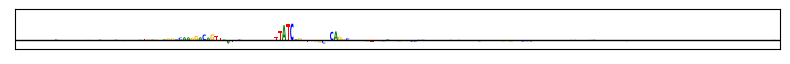

liver


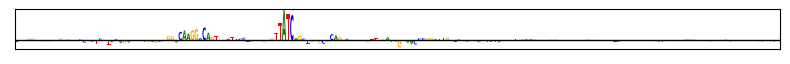

brain


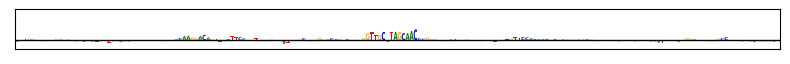

muscle


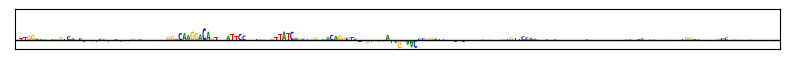

esophagus


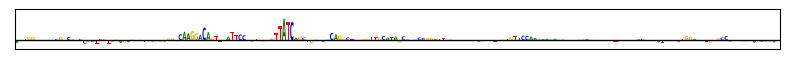

--------------------

-- Example = 30 --
 - ENSG00000100167(+)
 - chr22:41722100-42246388
 -- min_val = -1.29
 -- max_val = 0.65
 - (Gradient score profiles per tissue) - 


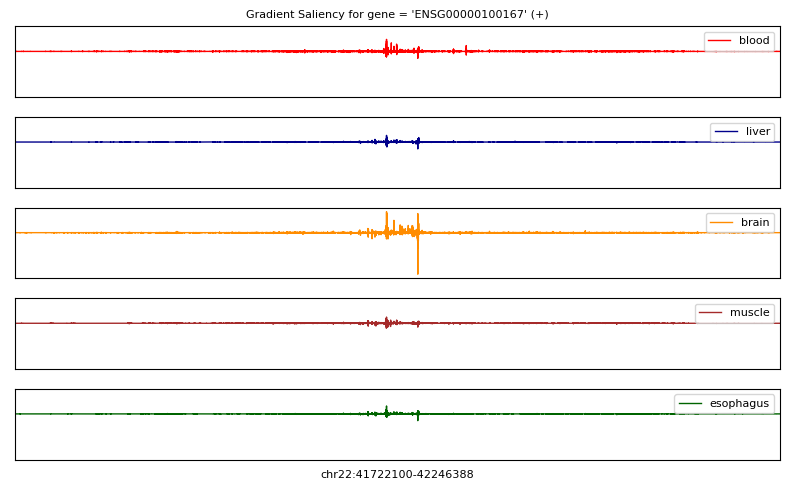

 - (Gradient score comparison against 'brain') - 
blood (r = 0.284)
liver (r = 0.299)
muscle (r = 0.285)
esophagus (r = 0.464)


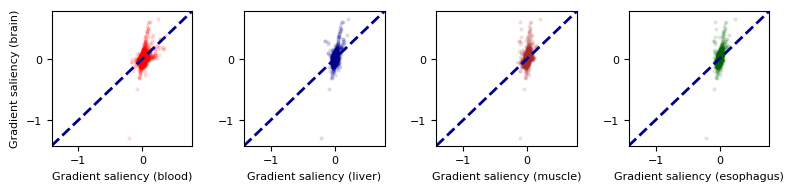

 - (Differential gradient score of brain against 'mean') -


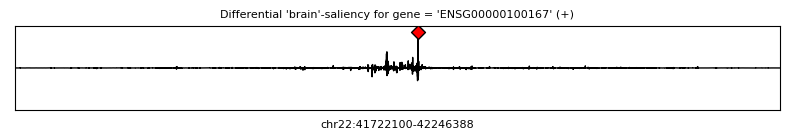

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 276133
 - max_pos (abs) = 41998233
 - chr22:41998137-41998329
blood


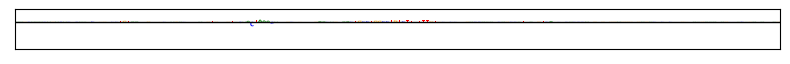

liver


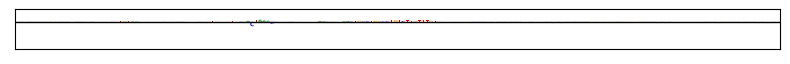

brain


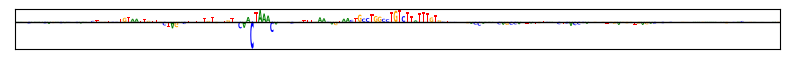

muscle


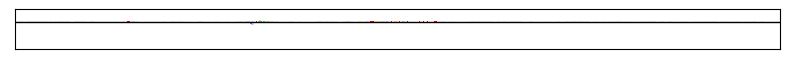

esophagus


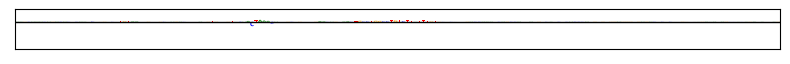

--------------------

-- Example = 31 --
 - ENSG00000157219(+)
 - chr7:154819351-155343639
 -- min_val = -0.3604
 -- max_val = 0.4175
 - (Gradient score profiles per tissue) - 


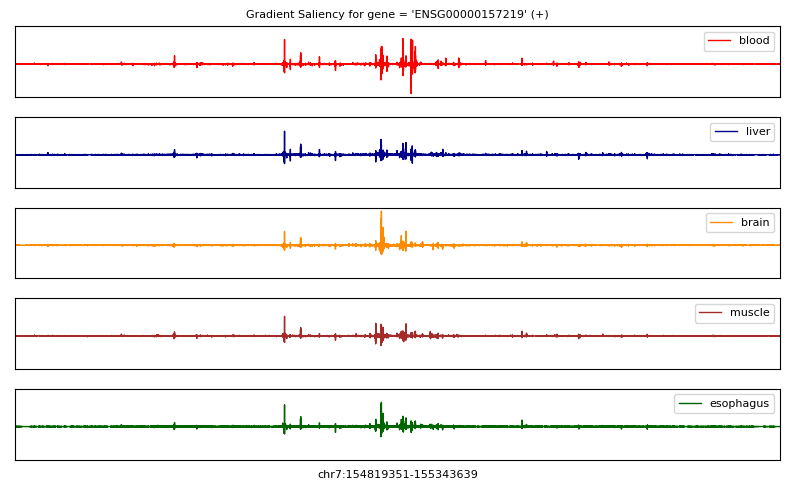

 - (Gradient score comparison against 'brain') - 
blood (r = 0.422)
liver (r = 0.474)
muscle (r = 0.515)
esophagus (r = 0.641)


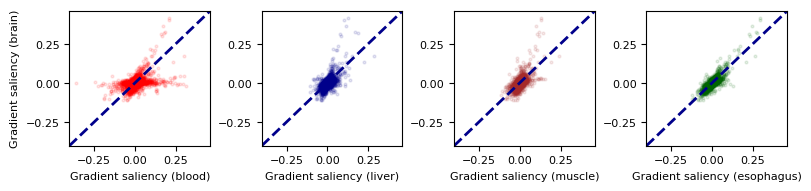

 - (Differential gradient score of brain against 'mean') -


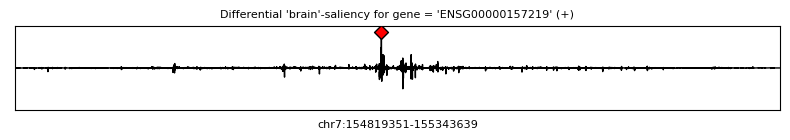

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251151
 - max_pos (abs) = 155070502
 - chr7:155070406-155070598
blood


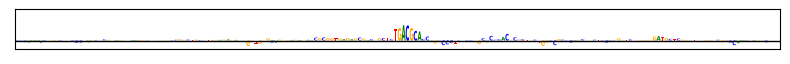

liver


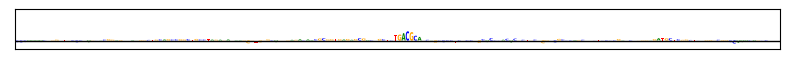

brain


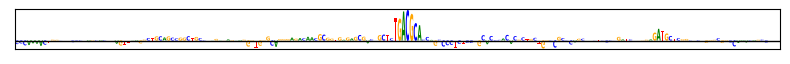

muscle


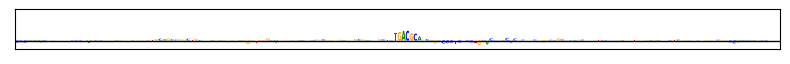

esophagus


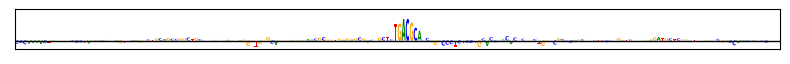

--------------------

-- Example = 32 --
 - ENSG00000077080(-)
 - chr7:100387310-100911598
 -- min_val = -0.7227
 -- max_val = 2.018
 - (Gradient score profiles per tissue) - 


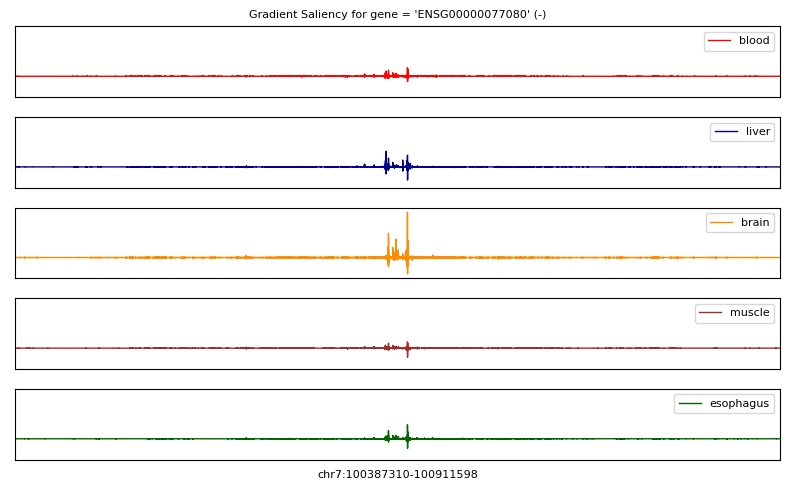

 - (Gradient score comparison against 'brain') - 
blood (r = 0.318)
liver (r = 0.123)
muscle (r = 0.332)
esophagus (r = 0.533)


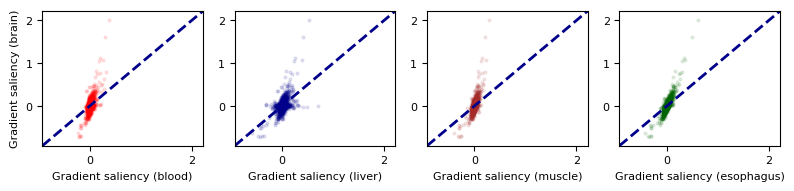

 - (Differential gradient score of brain against 'mean') -


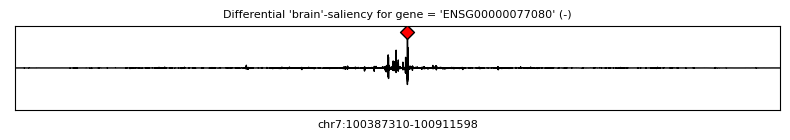

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 269019
 - max_pos (abs) = 100656329
 - chr7:100656233-100656425
blood


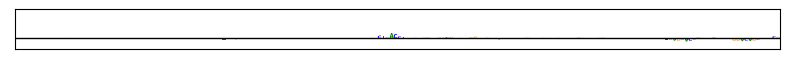

liver


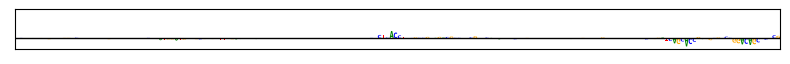

brain


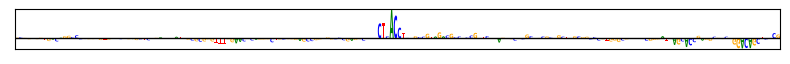

muscle


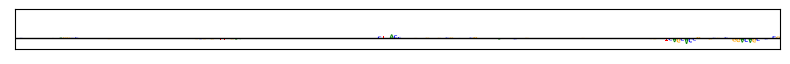

esophagus


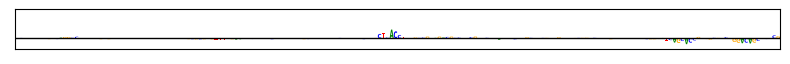

--------------------

-- Example = 33 --
 - ENSG00000136750(+)
 - chr10:26023917-26548205
 -- min_val = -0.9287
 -- max_val = 0.3933
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


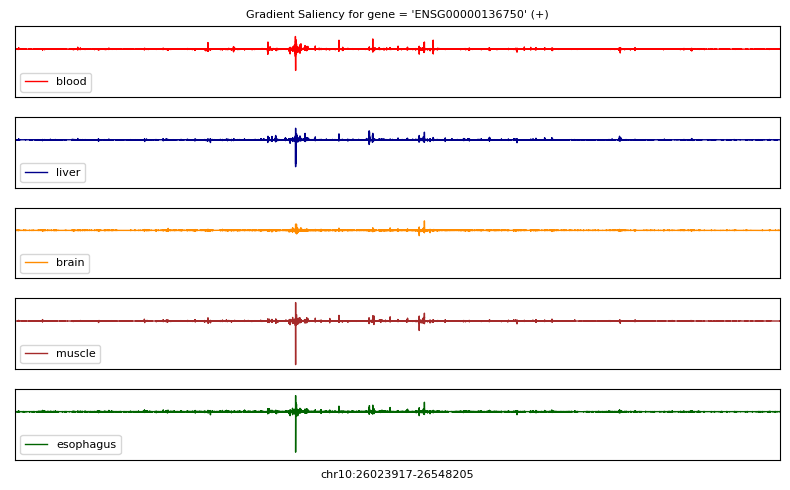

 - (Gradient score comparison against 'brain') - 
blood (r = 0.372)
liver (r = 0.247)
muscle (r = 0.382)
esophagus (r = 0.532)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


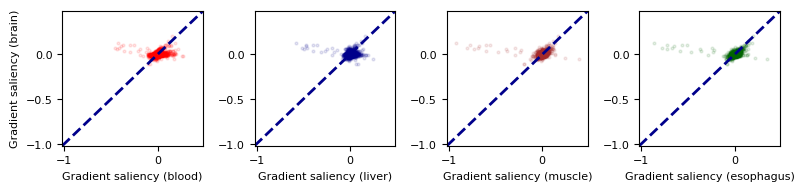

 - (Differential gradient score of brain against 'mean') -


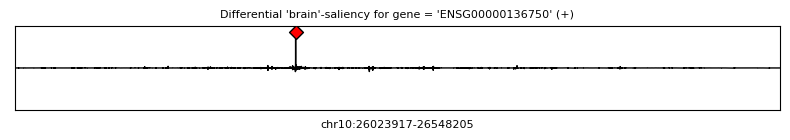

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 192384
 - max_pos (abs) = 26216301
 - chr10:26216205-26216397
blood


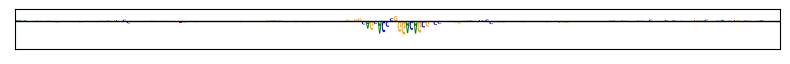

liver


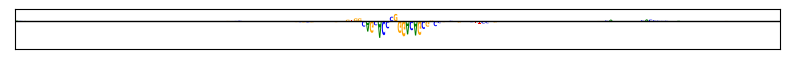

brain


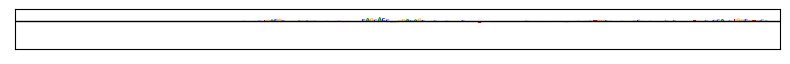

muscle


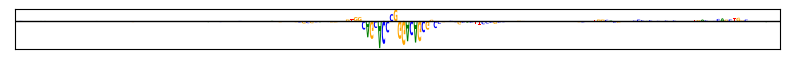

esophagus


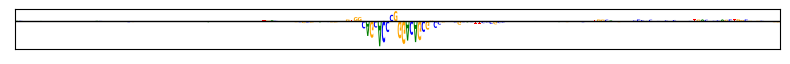

--------------------

-- Example = 34 --
 - ENSG00000121905(+)
 - chr1:32630427-33154715
 -- min_val = -0.7236
 -- max_val = 2.014
 - (Gradient score profiles per tissue) - 


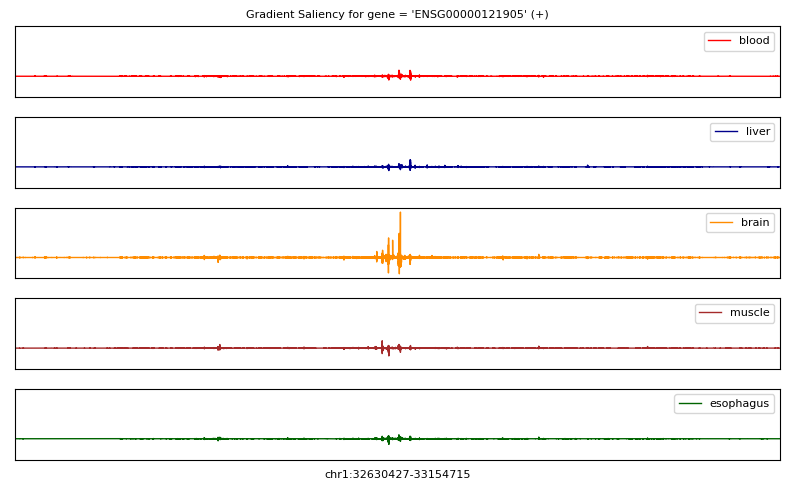

 - (Gradient score comparison against 'brain') - 
blood (r = 0.303)
liver (r = 0.151)
muscle (r = 0.281)
esophagus (r = 0.444)


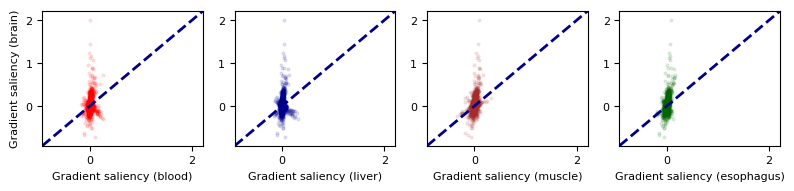

 - (Differential gradient score of brain against 'mean') -


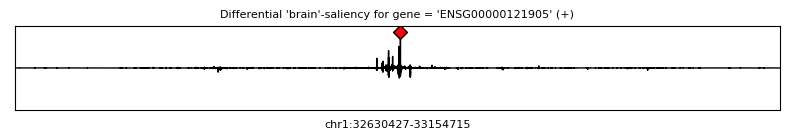

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 264200
 - max_pos (abs) = 32894627
 - chr1:32894531-32894723
blood


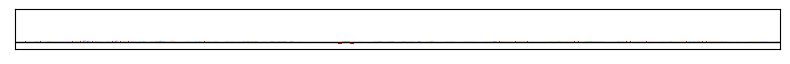

liver


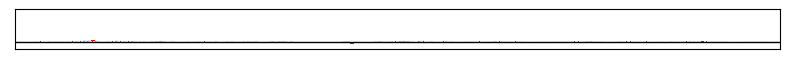

brain


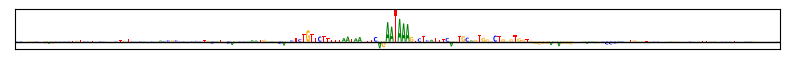

muscle


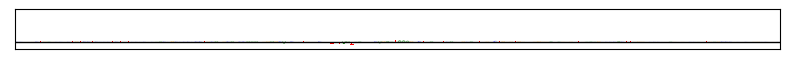

esophagus


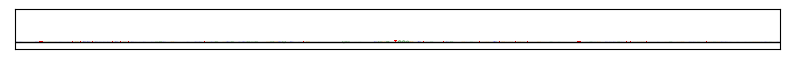

--------------------

-- Example = 35 --
 - ENSG00000175874(-)
 - chr2:101090260-101614548
 -- min_val = -0.619
 -- max_val = 1.609
 - (Gradient score profiles per tissue) - 


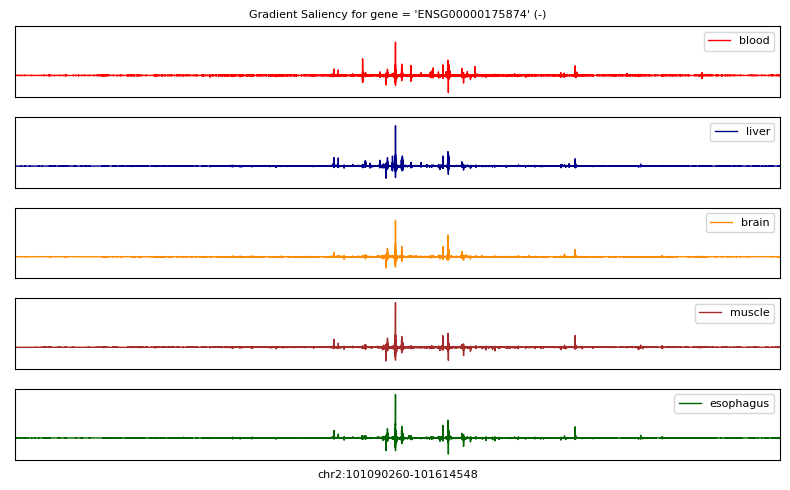

 - (Gradient score comparison against 'brain') - 
blood (r = 0.435)
liver (r = 0.48)
muscle (r = 0.616)
esophagus (r = 0.628)


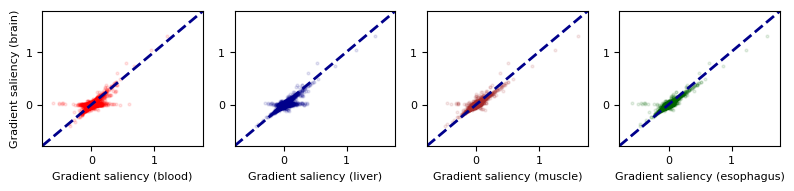

 - (Differential gradient score of brain against 'mean') -


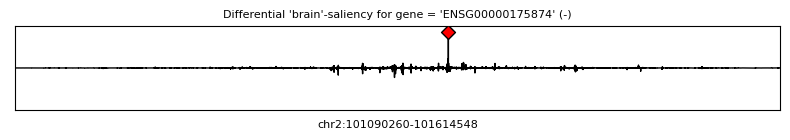

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 297044
 - max_pos (abs) = 101387304
 - chr2:101387208-101387400
blood


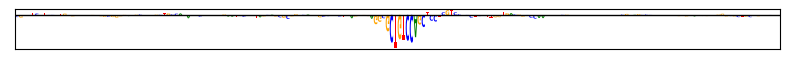

liver


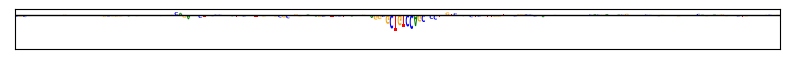

brain


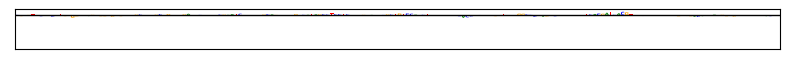

muscle


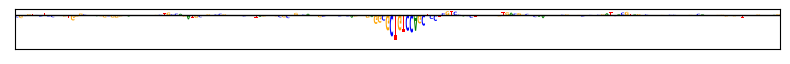

esophagus


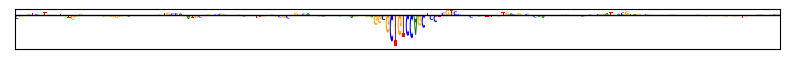

--------------------

-- Example = 36 --
 - ENSG00000204655(+)
 - chr6:29405576-29929864
 -- min_val = -0.575
 -- max_val = 1.19
 - (Gradient score profiles per tissue) - 


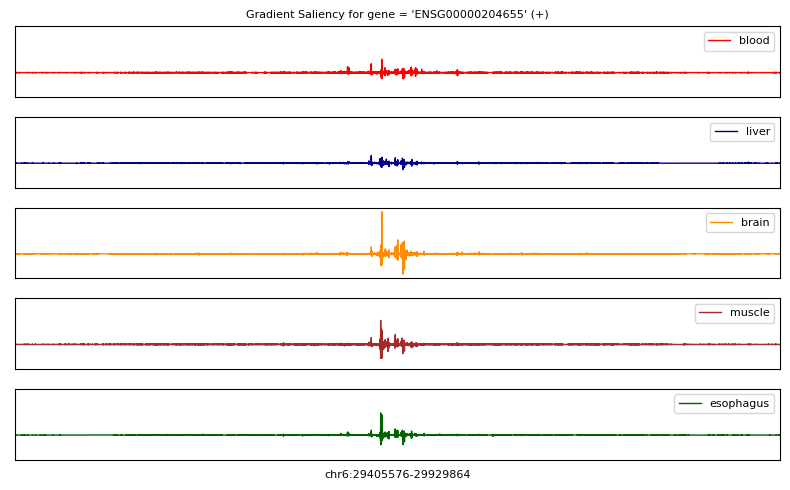

 - (Gradient score comparison against 'brain') - 
blood (r = 0.189)
liver (r = 0.201)
muscle (r = 0.215)
esophagus (r = 0.362)


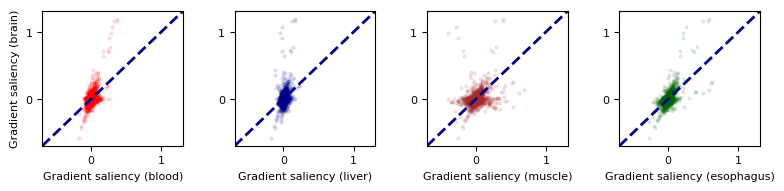

 - (Differential gradient score of brain against 'mean') -


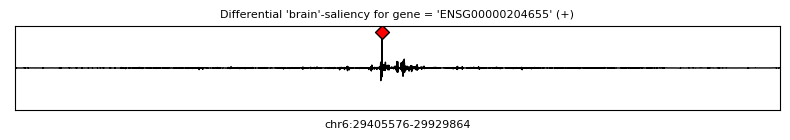

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251429
 - max_pos (abs) = 29657005
 - chr6:29656909-29657101
blood


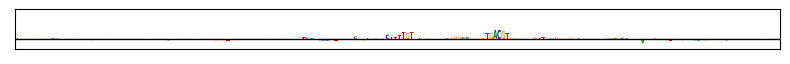

liver


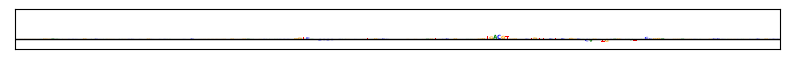

brain


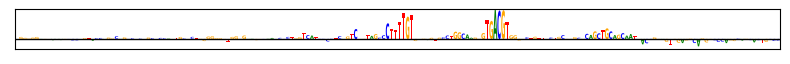

muscle


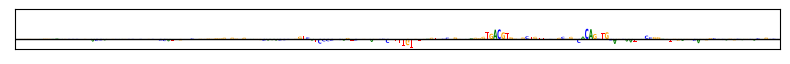

esophagus


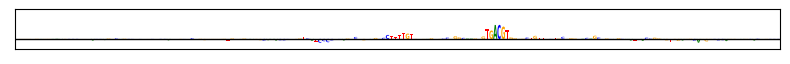

--------------------

-- Example = 37 --
 - ENSG00000120251(+)
 - chr4:157076268-157600556
 -- min_val = -0.7905
 -- max_val = 0.799
 - (Gradient score profiles per tissue) - 


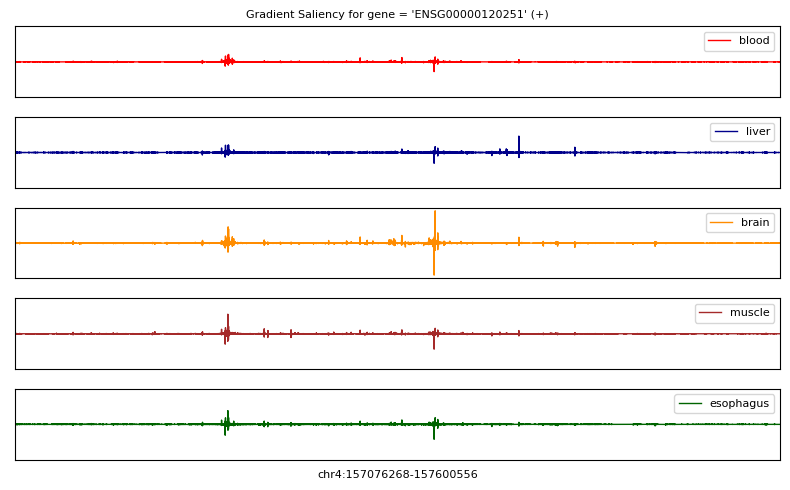

 - (Gradient score comparison against 'brain') - 
blood (r = 0.525)
liver (r = 0.458)
muscle (r = 0.557)
esophagus (r = 0.623)


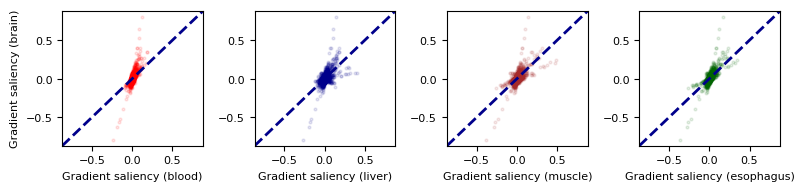

 - (Differential gradient score of brain against 'mean') -


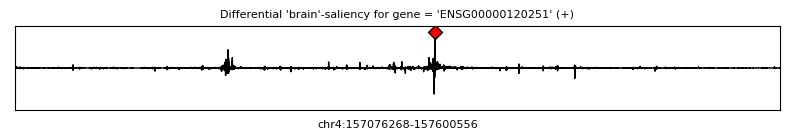

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 287997
 - max_pos (abs) = 157364265
 - chr4:157364169-157364361
blood


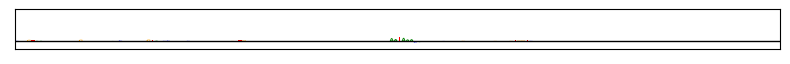

liver


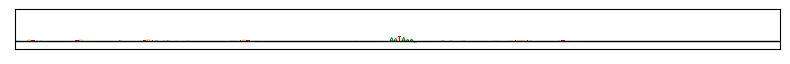

brain


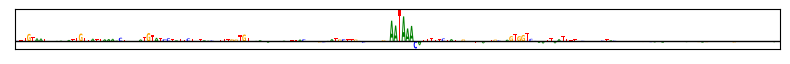

muscle


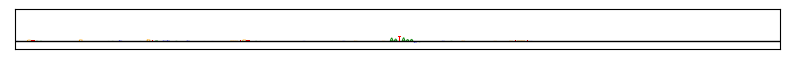

esophagus


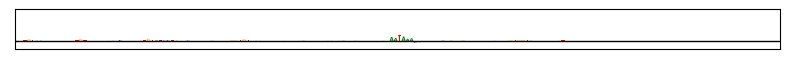

--------------------

-- Example = 38 --
 - ENSG00000182601(+)
 - chr16:25712335-26236623
 -- min_val = -0.1113
 -- max_val = 0.2299
 - (Gradient score profiles per tissue) - 


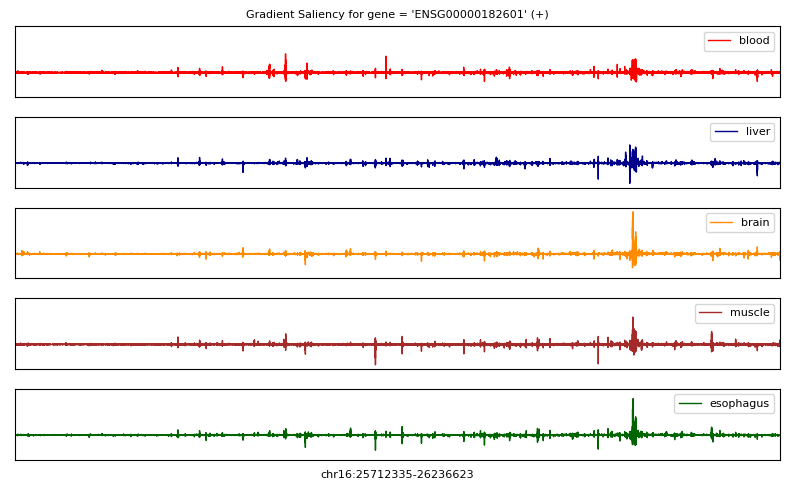

 - (Gradient score comparison against 'brain') - 
blood (r = 0.336)
liver (r = 0.25)
muscle (r = 0.356)
esophagus (r = 0.556)


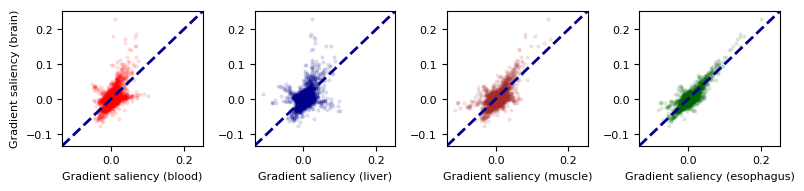

 - (Differential gradient score of brain against 'mean') -


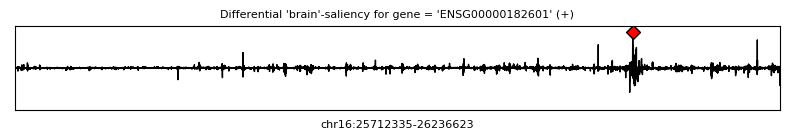

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 423395
 - max_pos (abs) = 26135730
 - chr16:26135634-26135826
blood


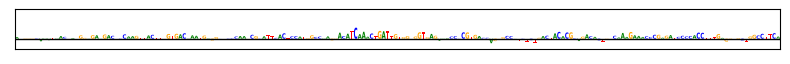

liver


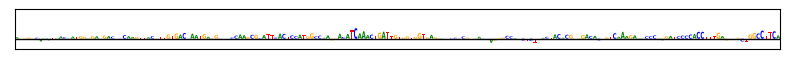

brain


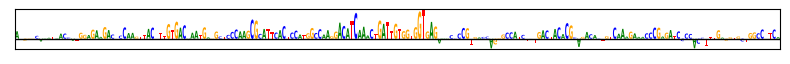

muscle


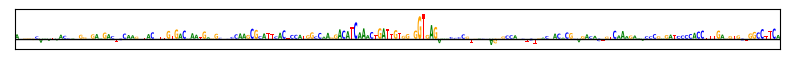

esophagus


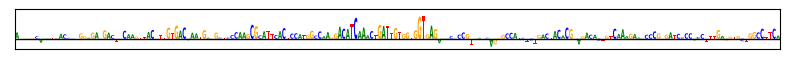

--------------------

-- Example = 39 --
 - ENSG00000144119(-)
 - chr2:118895419-119419707
 -- min_val = -0.4785
 -- max_val = 0.7417
 - (Gradient score profiles per tissue) - 


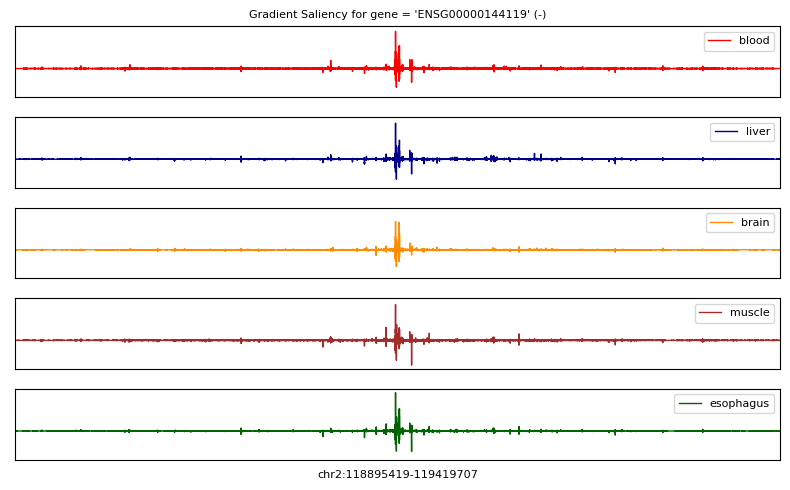

 - (Gradient score comparison against 'brain') - 
blood (r = 0.483)
liver (r = 0.483)
muscle (r = 0.444)
esophagus (r = 0.576)


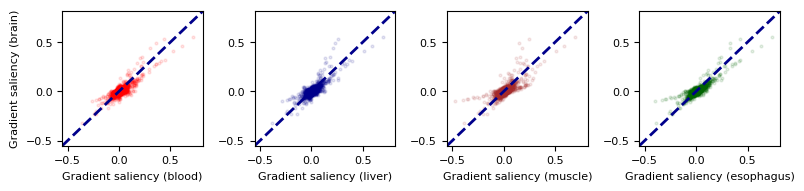

 - (Differential gradient score of brain against 'mean') -


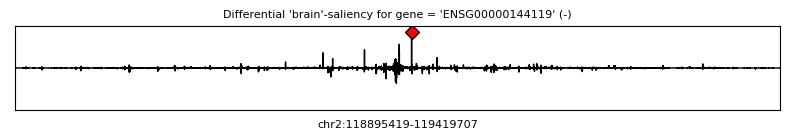

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 271846
 - max_pos (abs) = 119167265
 - chr2:119167169-119167361
blood


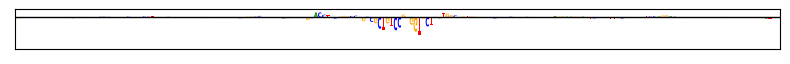

liver


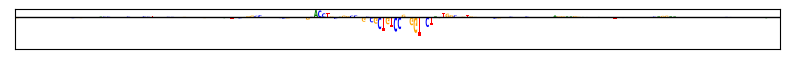

brain


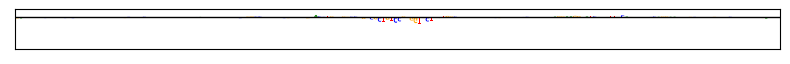

muscle


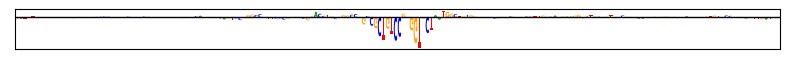

esophagus


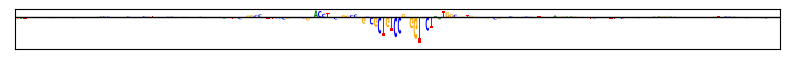

--------------------

-- Example = 40 --
 - ENSG00000074317(-)
 - chr5:176361731-176886019
 -- min_val = -0.817
 -- max_val = 1.765
 - (Gradient score profiles per tissue) - 


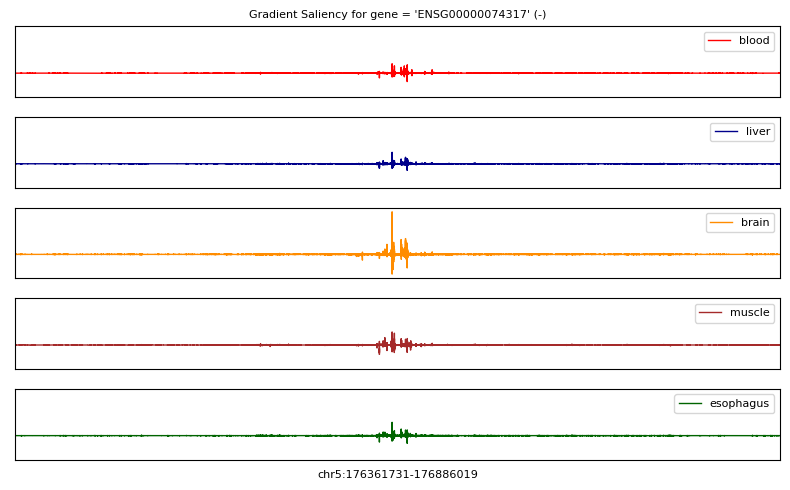

 - (Gradient score comparison against 'brain') - 
blood (r = 0.42)
liver (r = 0.425)
muscle (r = 0.35)
esophagus (r = 0.611)


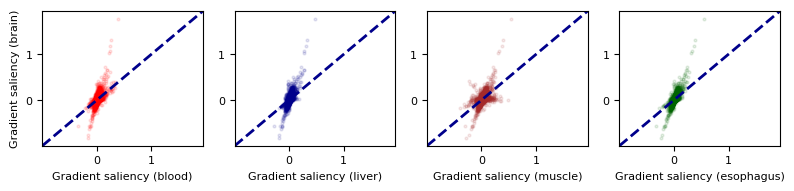

 - (Differential gradient score of brain against 'mean') -


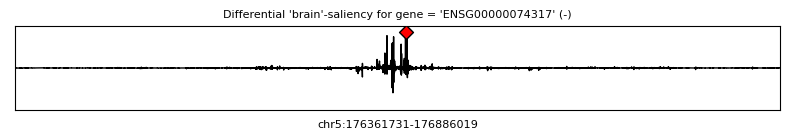

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 267695
 - max_pos (abs) = 176629426
 - chr5:176629330-176629522
blood


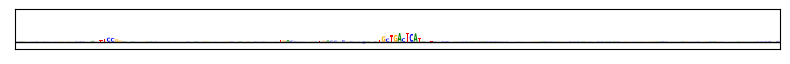

liver


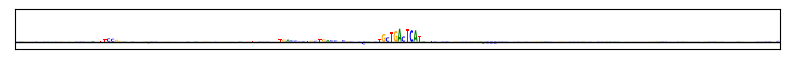

brain


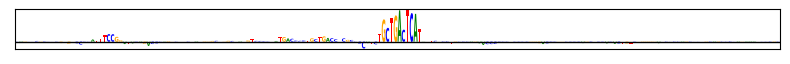

muscle


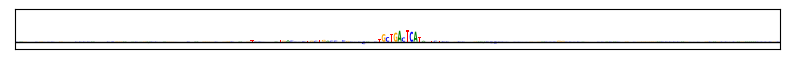

esophagus


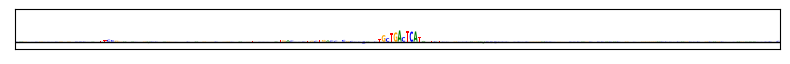

--------------------

-- Example = 41 --
 - ENSG00000111218(+)
 - chr12:3298331-3822619
 -- min_val = -0.912
 -- max_val = 0.4043
 - (Gradient score profiles per tissue) - 


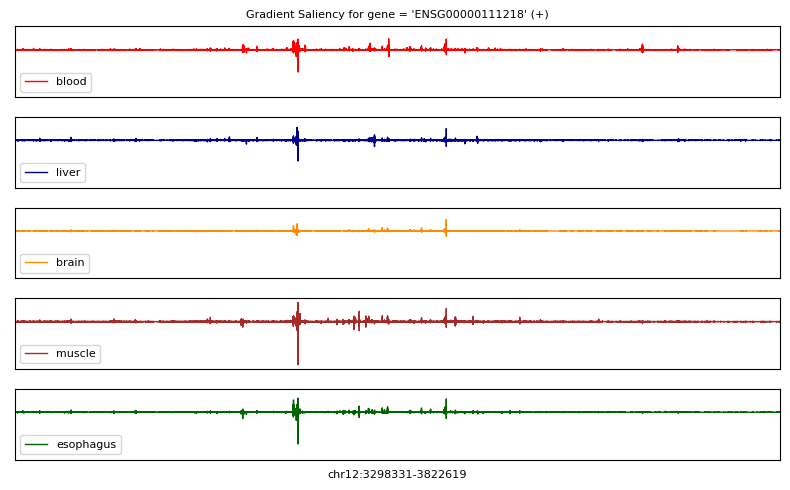

 - (Gradient score comparison against 'brain') - 
blood (r = 0.351)
liver (r = 0.384)
muscle (r = 0.317)
esophagus (r = 0.493)


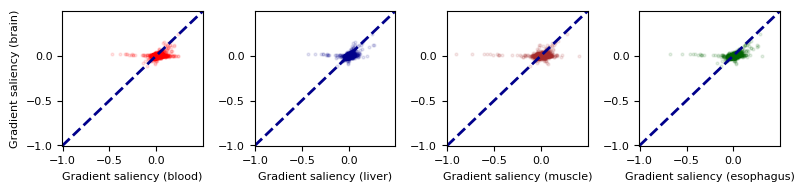

 - (Differential gradient score of brain against 'mean') -


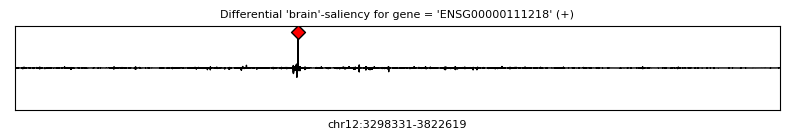

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 194051
 - max_pos (abs) = 3492382
 - chr12:3492286-3492478
blood


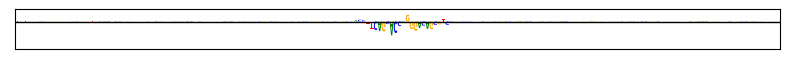

liver


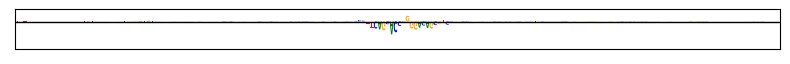

brain


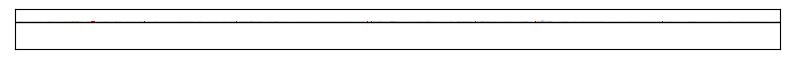

muscle


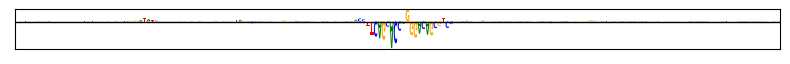

esophagus


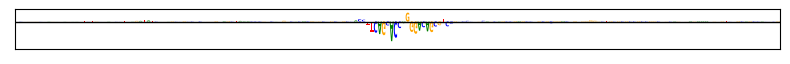

--------------------

-- Example = 42 --
 - ENSG00000237289(+)
 - chr15:43334302-43858590
 -- min_val = -0.5483
 -- max_val = 0.663
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


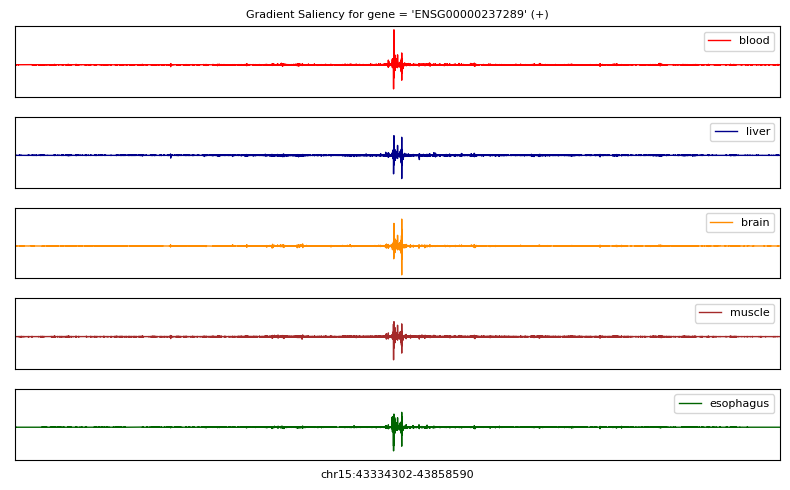

 - (Gradient score comparison against 'brain') - 
blood (r = 0.401)
liver (r = 0.299)
muscle (r = 0.454)
esophagus (r = 0.556)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


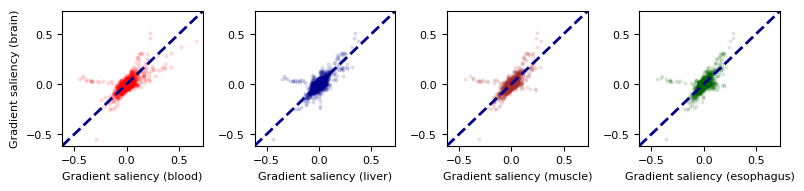

 - (Differential gradient score of brain against 'mean') -


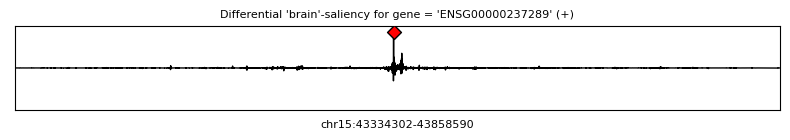

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 259499
 - max_pos (abs) = 43593801
 - chr15:43593705-43593897
blood


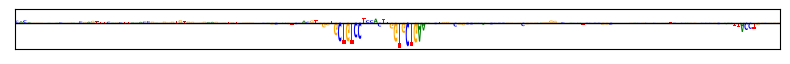

liver


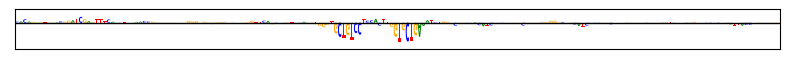

brain


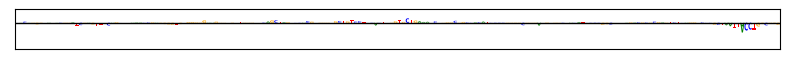

muscle


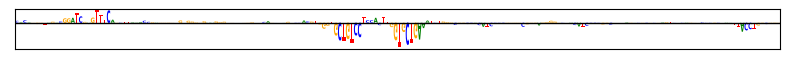

esophagus


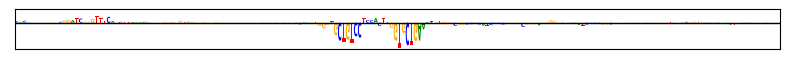

--------------------

-- Example = 43 --
 - ENSG00000124134(-)
 - chr20:44832442-45356730
 -- min_val = -0.455
 -- max_val = 0.7676
 - (Gradient score profiles per tissue) - 


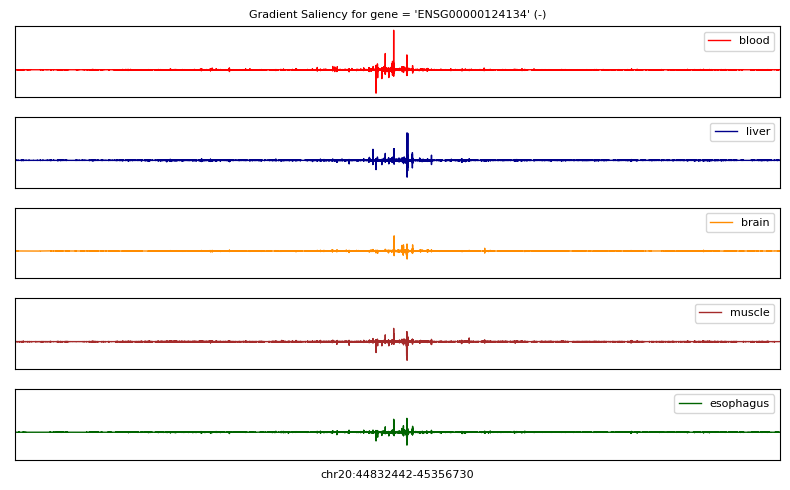

 - (Gradient score comparison against 'brain') - 
blood (r = 0.133)
liver (r = 0.152)
muscle (r = 0.27)
esophagus (r = 0.337)


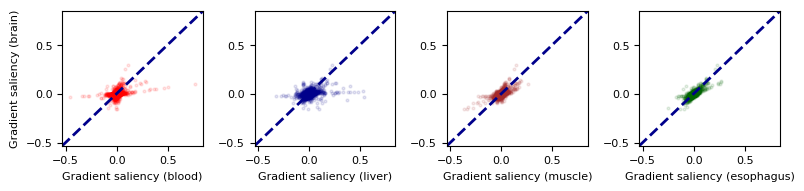

 - (Differential gradient score of brain against 'mean') -


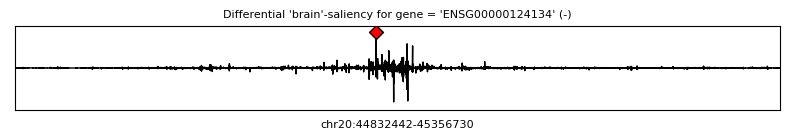

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 247487
 - max_pos (abs) = 45079929
 - chr20:45079833-45080025
blood


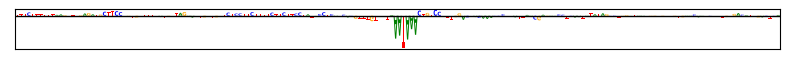

liver


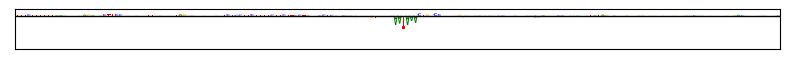

brain


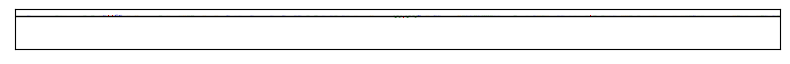

muscle


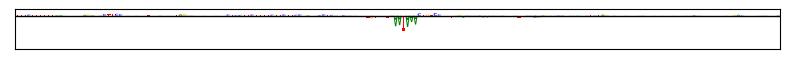

esophagus


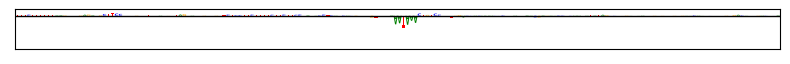

--------------------

-- Example = 44 --
 - ENSG00000198822(+)
 - chr7:86516056-87040344
 -- min_val = -0.1398
 -- max_val = 0.4067
 - (Gradient score profiles per tissue) - 


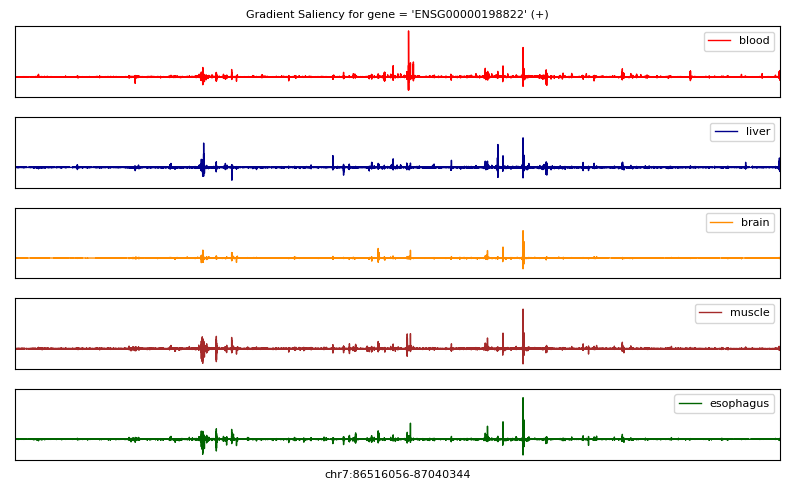

 - (Gradient score comparison against 'brain') - 
blood (r = 0.343)
liver (r = 0.241)
muscle (r = 0.472)
esophagus (r = 0.573)


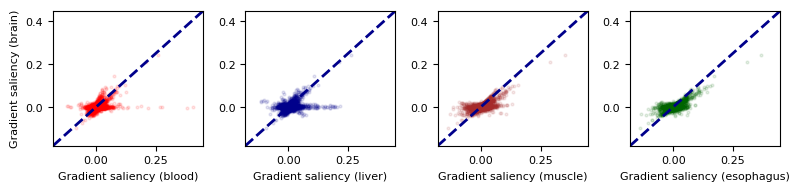

 - (Differential gradient score of brain against 'mean') -


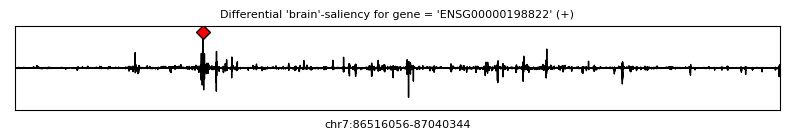

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 128780
 - max_pos (abs) = 86644836
 - chr7:86644740-86644932
blood


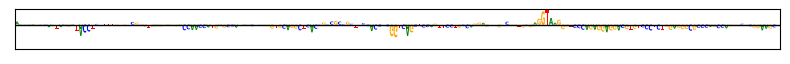

liver


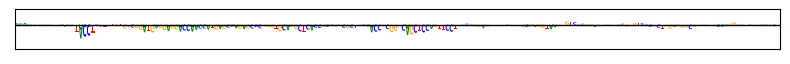

brain


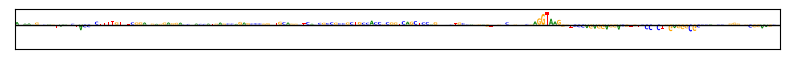

muscle


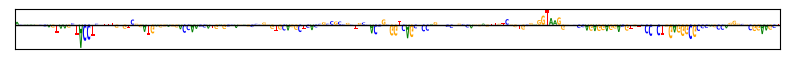

esophagus


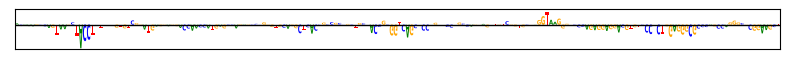

--------------------

-- Example = 45 --
 - ENSG00000111783(+)
 - chr12:106455265-106979553
 -- min_val = -0.2861
 -- max_val = 0.3203
 - (Gradient score profiles per tissue) - 


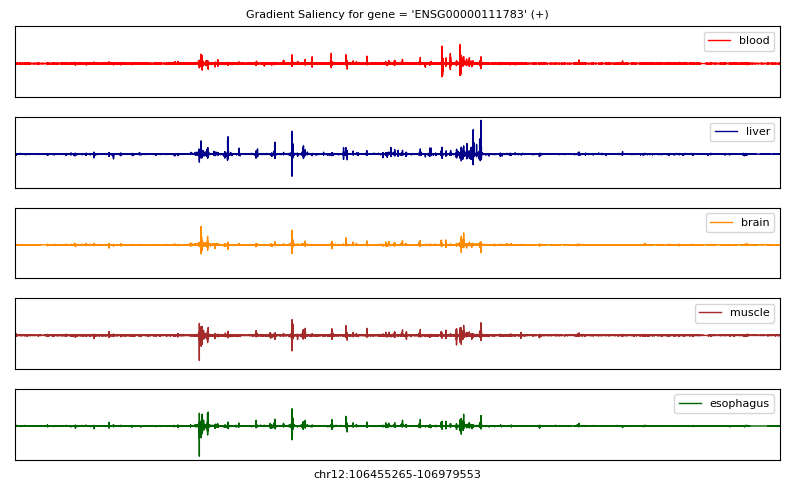

 - (Gradient score comparison against 'brain') - 
blood (r = 0.291)
liver (r = 0.223)
muscle (r = 0.374)
esophagus (r = 0.528)


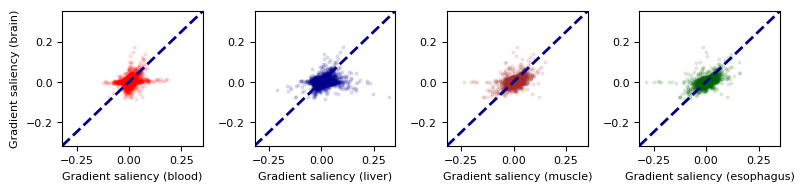

 - (Differential gradient score of brain against 'mean') -


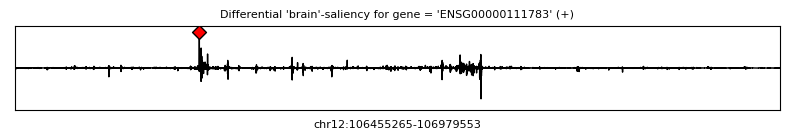

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 126404
 - max_pos (abs) = 106581669
 - chr12:106581573-106581765
blood


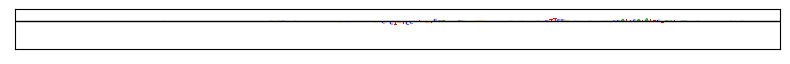

liver


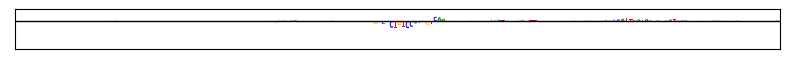

brain


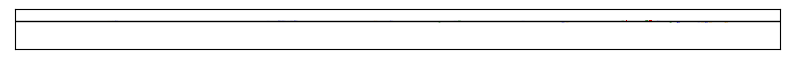

muscle


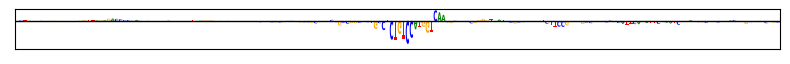

esophagus


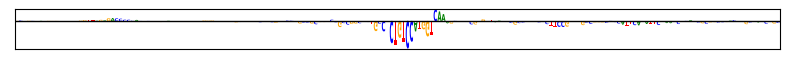

--------------------

-- Example = 46 --
 - ENSG00000250366(+)
 - chr14:95655194-96179482
 -- min_val = -0.37
 -- max_val = 0.3774
 - (Gradient score profiles per tissue) - 


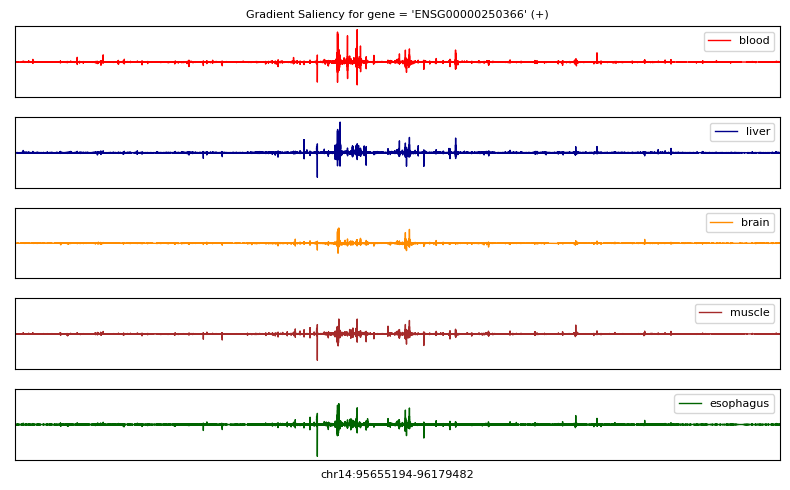

 - (Gradient score comparison against 'brain') - 
blood (r = 0.342)
liver (r = 0.366)
muscle (r = 0.521)
esophagus (r = 0.606)


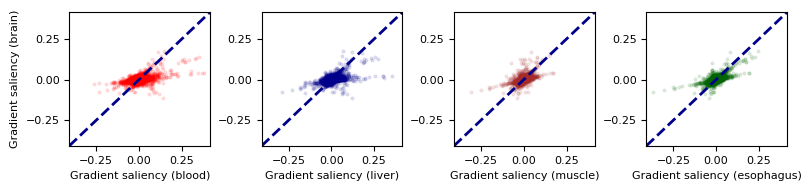

 - (Differential gradient score of brain against 'mean') -


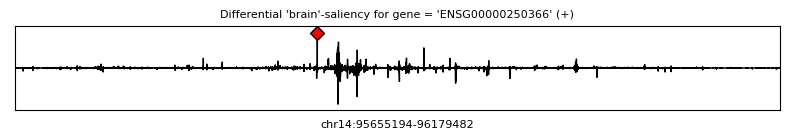

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 207254
 - max_pos (abs) = 95862448
 - chr14:95862352-95862544
blood


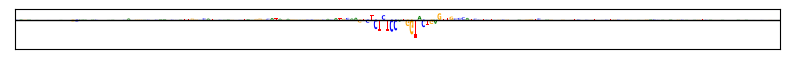

liver


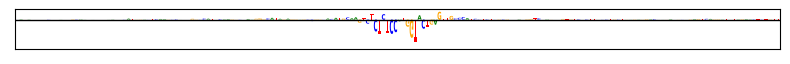

brain


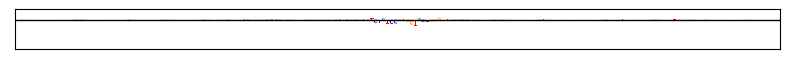

muscle


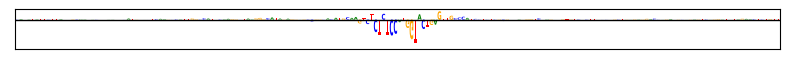

esophagus


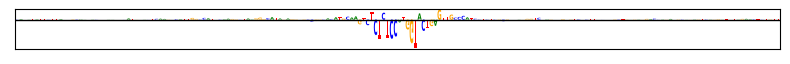

--------------------

-- Example = 47 --
 - ENSG00000168539(-)
 - chr11:62648410-63172698
 -- min_val = -0.5854
 -- max_val = 0.951
 - (Gradient score profiles per tissue) - 


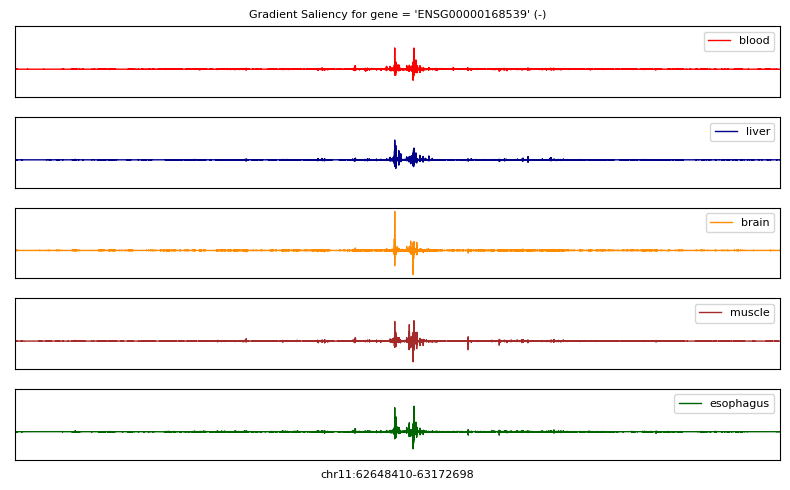

 - (Gradient score comparison against 'brain') - 
blood (r = 0.248)
liver (r = 0.154)
muscle (r = 0.278)
esophagus (r = 0.31)


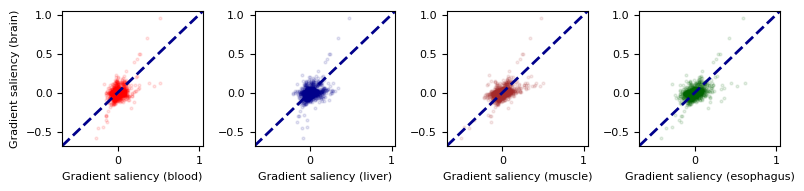

 - (Differential gradient score of brain against 'mean') -


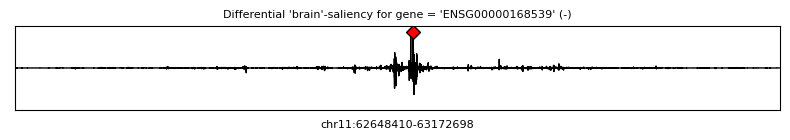

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 272943
 - max_pos (abs) = 62921353
 - chr11:62921257-62921449
blood


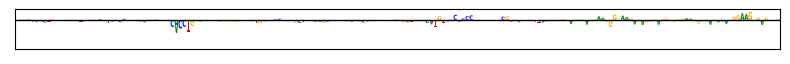

liver


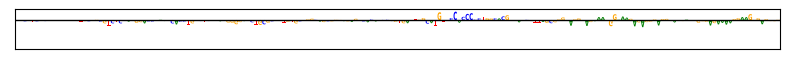

brain


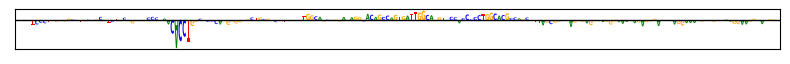

muscle


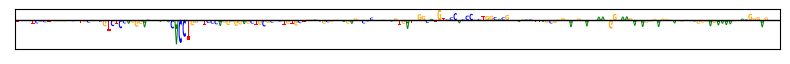

esophagus


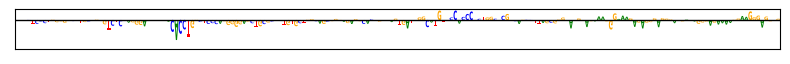

--------------------

-- Example = 48 --
 - ENSG00000163630(+)
 - chr3:63300627-63824915
 -- min_val = -0.828
 -- max_val = 1.617
 - (Gradient score profiles per tissue) - 


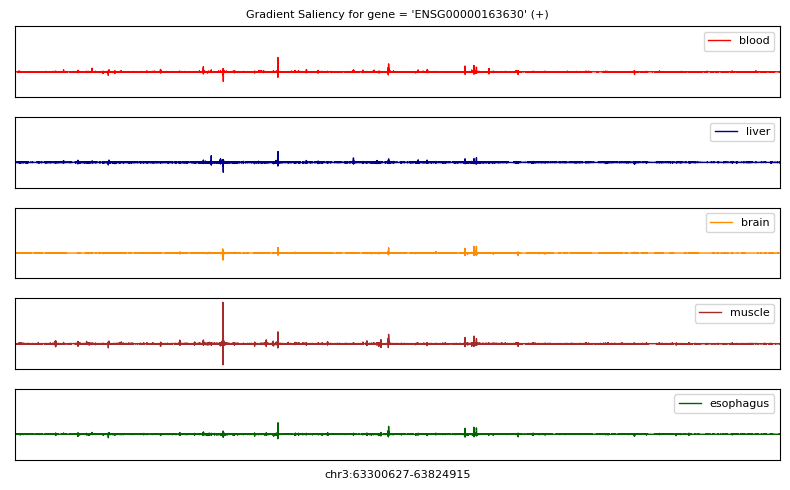

 - (Gradient score comparison against 'brain') - 
blood (r = 0.369)
liver (r = 0.272)
muscle (r = 0.293)
esophagus (r = 0.462)


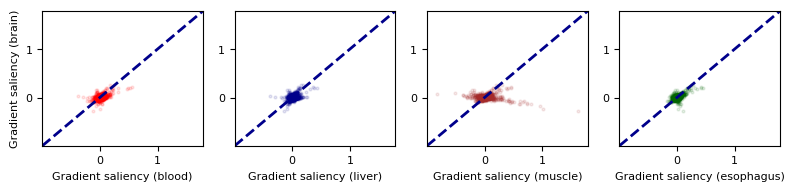

 - (Differential gradient score of brain against 'mean') -


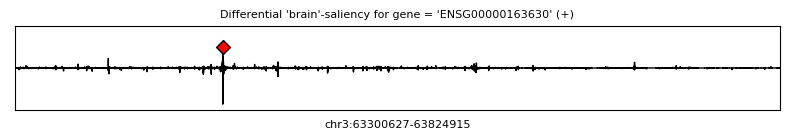

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 142432
 - max_pos (abs) = 63443059
 - chr3:63442963-63443155
blood


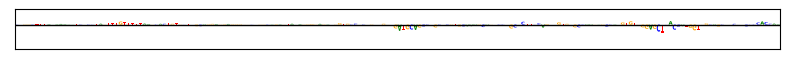

liver


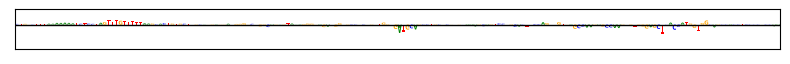

brain


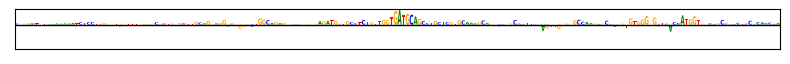

muscle


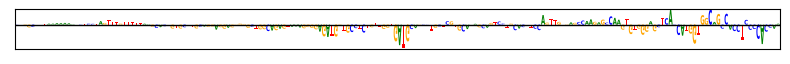

esophagus


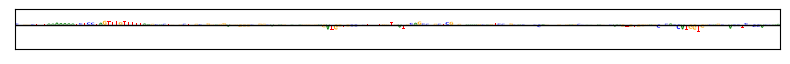

--------------------

-- Example = 49 --
 - ENSG00000130477(-)
 - chr19:17361733-17886021
 -- min_val = -0.4512
 -- max_val = 0.659
 - (Gradient score profiles per tissue) - 


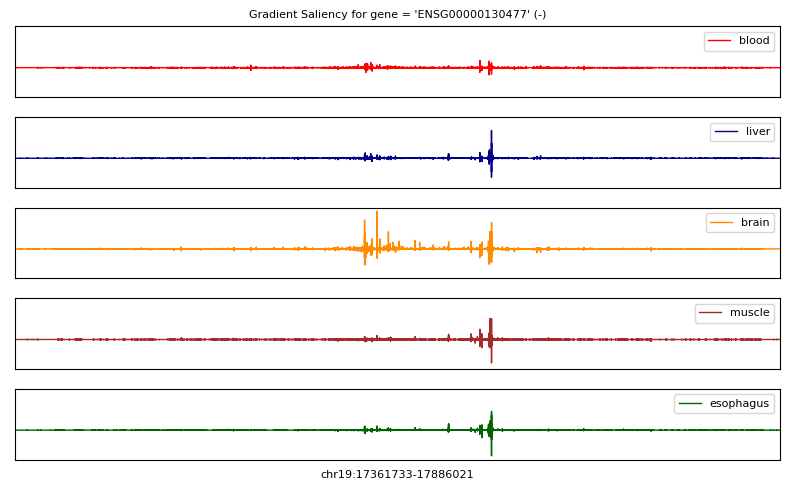

 - (Gradient score comparison against 'brain') - 
blood (r = 0.22)
liver (r = 0.137)
muscle (r = 0.286)
esophagus (r = 0.418)


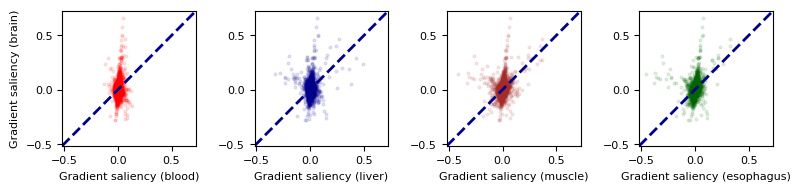

 - (Differential gradient score of brain against 'mean') -


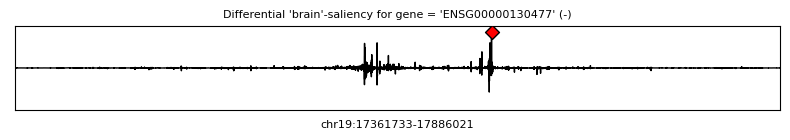

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 326612
 - max_pos (abs) = 17688345
 - chr19:17688249-17688441
blood


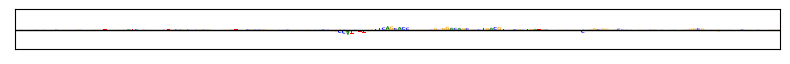

liver


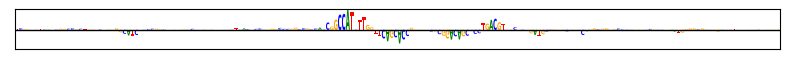

brain


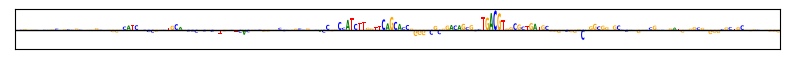

muscle


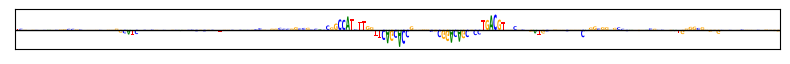

esophagus


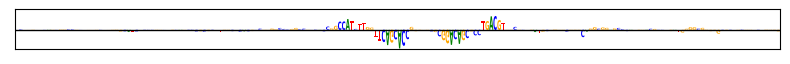

--------------------



In [7]:
#Enumerate and visualize attributions (relative fold changes); brain

save_figs = True
save_prefix = 'attribution_figs/borzoi_v2_diff_expr_grads_5_tissues_4_folds_' + tissue

save_index = [3, 14, 24, 33, 42]

#Select tissue to find maximally differential score locus for
main_tissue_ix = 2

#Visualization parameters
logo_width = 192

top_n = 50

use_gaussian = True
min_padding = 65536
gaussian_sigma = 8

tissue_colors = ['red', 'darkblue', 'darkorange', 'brown', 'darkgreen']

#Loop over examples
for example_ix in range(top_n) :
    
    print("-- Example = " + str(example_ix)+ " --")
    
    save_figs_curr = False
    if save_figs and example_ix in set(save_index) :
        save_figs_curr = True
    
    print(" - " + tissue_genes[example_ix] + "(" + str(strands[example_ix]) + ")")
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]))

    #Grad analysis
    
    #Calculate min and max scores globally (for scales)
    min_val = np.min(scores[:, example_ix, ...])
    max_val = np.max(scores[:, example_ix, ...])
    
    print(" -- min_val = " + str(round(min_val, 4)))
    print(" -- max_val = " + str(round(max_val, 4)))
    
    max_abs_val = max(np.abs(min_val), np.abs(max_val))

    min_val -= 0.1 * max_abs_val
    max_val += 0.1 * max_abs_val

    print(" - (Gradient score profiles per tissue) - ")
    
    #Gradient profiles across input sequence
    f, ax = plt.subplots(len(gtex_tissues), 1, figsize=(8, len(gtex_tissues) * 1))

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :

        #Get tissue scores
        score = scores[tissue_ix, example_ix, ...]

        l1 = ax[tissue_ix].plot(np.arange(seqs.shape[1]), np.sum(score, axis=-1), linewidth=1, linestyle='-', color=tissue_colors[tissue_ix], label=gtex_tissues[tissue_ix])
        
        plt.sca(ax[tissue_ix])
        
        plt.xlim(0, seqs.shape[1])
        plt.ylim(min_val, max_val)
        
        plt.legend(handles=[l1[0]], fontsize=8)
        
        plt.yticks([], [])
        plt.xticks([], [])
    
    plt.sca(ax[0])
    plt.title("Gradient Saliency for gene = '" + tissue_genes[example_ix] + "' (" + str(strands[example_ix]) + ")", fontsize=8)
    
    plt.sca(ax[len(gtex_tissues)-1])
    plt.xlabel(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]), fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_scores_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_scores_example_ix_' + str(example_ix) + ".eps")
    
    plt.show()
    
    print(" - (Gradient score comparison against '" + gtex_tissues[main_tissue_ix] + "') - ")

    #Scatter plots of pairs of tissue-specific gradient scores
    f, ax = plt.subplots(1, len(gtex_tissues)-1, figsize=((len(gtex_tissues)-1) * 2, 2))
    
    #Gradient saliency for main tissue
    score_2 = scores[main_tissue_ix, example_ix, ...]

    #Loop over (other) tissues
    ax_ix = 0
    for tissue_ix in range(len(gtex_tissues)) :

        if tissue_ix != main_tissue_ix :
            
            #Gradient saliency for other tissue
            score_1 = scores[tissue_ix, example_ix, ...]
            
            #Compute spearman correlation between scores
            r_val, _ = spearmanr(np.sum(score_1, axis=-1), np.sum(score_2, axis=-1))
            
            #Print stats
            print(gtex_tissues[tissue_ix] + " (r = " + str(round(r_val, 3)) + ")")

            #Scatter plot of scores
            ax[ax_ix].scatter(np.sum(score_1, axis=-1), np.sum(score_2, axis=-1), s=4, color=tissue_colors[tissue_ix], alpha=0.1)

            ax[ax_ix].plot([min_val, max_val], [min_val, max_val], linewidth=2, linestyle='--', color='darkblue')

            plt.sca(ax[ax_ix])
            
            plt.xlim(min_val, max_val)
            plt.ylim(min_val, max_val)
            
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)

            plt.xlabel("Gradient saliency (" + gtex_tissues[tissue_ix] + ")", fontsize=8)
            
            ax_ix += 1

    plt.sca(ax[0])
    plt.ylabel("Gradient saliency (" + gtex_tissues[main_tissue_ix] + ")", fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".eps")

    plt.show()

    print(" - (Differential gradient score of " + gtex_tissues[main_tissue_ix] + " against 'mean') -")

    #Get main tissue scores and background scores
    score_2 = scores[main_tissue_ix, example_ix, ...]
    score_1 = np.mean(scores[np.arange(len(gtex_tissues)) != main_tissue_ix, example_ix, ...], axis=0)

    #Compute differential scores
    diff_score = np.sum(score_2 - score_1, axis=-1)
    
    #Apply gaussian filter
    if use_gaussian :
        diff_score = gaussian_filter1d(diff_score.astype('float32'), sigma=gaussian_sigma, truncate=2).astype('float16')
    
    #Calculate min/max positions and (differential) values
    max_pos = np.argmax(diff_score[min_padding:-min_padding]) + min_padding
    min_pos = np.argmin(diff_score[min_padding:-min_padding]) + min_padding

    max_val = np.max(diff_score[min_padding:-min_padding])
    min_val = np.min(diff_score[min_padding:-min_padding])
    
    max_abs_val = max(np.abs(max_val), np.abs(min_val))

    #Plot differential scores
    f = plt.figure(figsize=(8, 1.5))

    plt.plot(np.arange(seqs.shape[1]), diff_score, color='black', linewidth=1, linestyle='-')
    
    plt.scatter([max_pos], [max_val], color='red', marker='D', s=50, linewidth=1, edgecolor='black', zorder=1000)

    plt.xlim(0, seqs.shape[1])
    plt.ylim(-max_abs_val*1.15, max_abs_val*1.15)
    
    plt.xticks([], [])
    plt.yticks([], [])

    plt.title("Differential '" + gtex_tissues[main_tissue_ix] + "'-saliency for gene = '" + tissue_genes[example_ix] + "' (" + str(strands[example_ix]) + ")", fontsize=8)
    
    plt.xlabel(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]), fontsize=8)
    
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_diff_scores_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_diff_scores_example_ix_' + str(example_ix) + ".eps")

    plt.show()

    print(" - (Attribution at position of Max positive differential saliency) -")

    print(" - max_pos (rel) = " + str(max_pos))
    print(" - max_pos (abs) = " + str(starts[example_ix] + max_pos))
    
    #Visualize contribution scores
    plot_start = max_pos - logo_width // 2
    plot_end = max_pos + logo_width // 2
    
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix] + max_pos - logo_width // 2) + "-" + str(starts[example_ix] + max_pos + logo_width // 2))

    #Logo min/max value across tissues
    min_logo_val = np.min(scores[:, example_ix, plot_start:plot_end, :])
    max_logo_val = np.max(scores[:, example_ix, plot_start:plot_end, :])

    max_abs_logo_val = max(np.abs(min_logo_val), np.abs(max_logo_val))

    min_logo_val -= 0.02 * max_abs_logo_val
    max_logo_val += 0.02 * max_abs_logo_val

    print(" - y_min = " + str(round(min_logo_val, 8)))
    print(" - y_max = " + str(round(max_logo_val, 8)))

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :
        print(gtex_tissues[tissue_ix])

        #Get tissue-specific scores
        score = scores[tissue_ix, example_ix, plot_start:plot_end, :]

        #Plot scores as sequence logo
        plot_seq_scores(
            score,
            y_min=min_logo_val,
            y_max=max_logo_val,
            figsize=(8, 0.75),
            plot_y_ticks=False,
            save_figs=save_figs_curr,
            fig_name=save_prefix + '_logo_example_ix_' + str(example_ix) + '_tissue_ix_' + str(tissue_ix),
        )
    
    print("--------------------")
    print("")
